# Prediction of Pre-miRNAs using deep learning models

## Config Steps

In [1]:
import os
from Bio import SeqIO
import numpy as np
from gensim.models import Word2Vec
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import f1_score as f1_score_sklearn
from sklearn.metrics import confusion_matrix, classification_report
import time
import seaborn as sns
import pandas as pd
import random
from collections import Counter
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from itertools import product

from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
import plotly.express as px
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from collections import defaultdict
import re
from matplotlib.colors import LinearSegmentedColormap

ModuleNotFoundError: No module named 'Bio'

In [ ]:
path = os.getcwd()
path

'/home/jopazo/premiRNAProject/IAPUCP_Server'

In [ ]:
models_metrics = {
    'precision': {},
    'recall': {},
    'f1': {},
    'TPR': {},
    'TNR': {},
    'probs_list': {}
}

## Methods

In [ ]:
def get_complementary_sequence(sequences):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return [''.join(complement[base] for base in seq) for seq in sequences]
def convert_RNA_sequence_to_DNA(sequence):
    return sequence.replace('U', 'T')

def convert_DNA_sequence_to_RNA(sequence):
    return sequence.replace('T', 'U')


# Convertir las secuencias de k-mers a secuencias de índices
def sequence_to_indices(sequence, mer_to_index):
    return [mer_to_index[mer] for mer in sequence if mer in mer_to_index]

def get_vocab(comb_length=3):
    # Definir los caracteres y la longitud de las combinaciones
    chars = ['A', 'C', 'G', 'T']

    # Generar todas las combinaciones posibles de longitud n
    return [''.join(comb) for comb in product(chars, repeat=comb_length)]

def get_sequence_for_screening(mirna_gap, mirna_seqs):
    premir_positions= []
    sequence_for_screening = FastaManager.read_fasta(random.choice([
            neg_seq_chr1_1_path,
            neg_seq_chr2_1_path,
            neg_seq_chr1_2_path,
            neg_seq_chr1_3_path,
        ]))[0][:mirna_gap]
    for mirna_seq in mirna_seqs:
        initial_pos_for_neg_sample = 1000*random.randrange(5)
        neg_seq = FastaManager.read_fasta(random.choice([
            neg_seq_chr1_1_path,
            neg_seq_chr2_1_path,
            neg_seq_chr1_2_path,
            neg_seq_chr1_3_path,
        ]))[0][initial_pos_for_neg_sample:initial_pos_for_neg_sample+mirna_gap]

        premir_positions.append({
            'start': len(sequence_for_screening),
            'end': len(sequence_for_screening) + mirna_seq['length']
        })
        sequence_for_screening += mirna_seq['sequence'] + neg_seq

    return {
        'seq': sequence_for_screening,
        'pos': premir_positions
    }

def preprocess_dna_sequences(sequences, max_seq_len):
    """
    Preprocess DNA sequences into one-hot encoded matrices with padding.

    Parameters:
    - sequences (list of str): List of DNA sequences.

    Returns:
    - one_hot_matrix (np.ndarray): One-hot encoded matrix with padding.
    """
    # Define the nucleotide mapping for one-hot encoding
    nucleotide_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    # Initialize a zero matrix for one-hot encoding
    one_hot_matrix = np.zeros((len(sequences), max_seq_len, len(nucleotide_to_index)))

    for i, seq in enumerate(sequences):
        for j, nucleotide in enumerate(seq):
            if nucleotide in nucleotide_to_index:
                # Set the corresponding position to 1
                one_hot_matrix[i, j, nucleotide_to_index[nucleotide]] = 1

    return one_hot_matrix

def pad_and_randomize_sequences(sequences, target_length=164, multiplier=1):
    nucleotides = ['A', 'T', 'C', 'G']
    transformed_sequences = []
    
    for _ in range(multiplier):
        for seq in sequences:
            seq_length = len(seq)
            
            if seq_length >= target_length:
                transformed_sequences.append(seq[:target_length])  # Truncate if too long
                continue
            
            padding_length = target_length - seq_length
            padding = ''.join(random.choices(nucleotides, k=padding_length))
            
            # Randomly position the original sequence within the new padded sequence
            start_idx = random.randint(0, padding_length)
            new_seq = padding[:start_idx] + seq + padding[start_idx:]
            
            transformed_sequences.append(new_seq)
    
    return transformed_sequences


def update_models_metrics(model_name, model, test_loader, models_metrics, device='cpu'):
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            y_test_pred = model(X_test_batch).round()
            all_preds.append(y_test_pred.cpu())
            all_labels.append(y_test_batch.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    report = classification_report(all_labels, all_preds, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # Add metrics to your main dict
    for metric in ['precision', 'recall', 'f1-score']:
        if metric not in models_metrics:
            models_metrics[metric] = {}
        for label in df_report.index:
            if label in ['accuracy', 'macro avg', 'weighted avg']:
                continue  # Skip these aggregate entries

            label_clean = str(int(float(label)))  # Converts '0.0' → '0' or 0 → '0'
            key = f"{model_name}_{'negative' if label_clean == '0' else 'positive'}"

            if key not in models_metrics[metric]:
                models_metrics[metric][key] = df_report.loc[label, metric]

    # Store predictions (as a flat list)
    if 'predictions' not in models_metrics:
        models_metrics['predictions'] = {}
    try:
        models_metrics['predictions'][model_name] = torch.cat(all_preds).numpy().flatten()
    except TypeError:
        models_metrics['predictions'][model_name] = all_preds.tolist()
        
    if 'labels' not in models_metrics:
        try:
                    models_metrics['labels'] = torch.cat(all_labels).numpy().flatten()#all_labels.tolist()

        except TypeError:
            models_metrics['labels'] = all_labels.tolist()


## Visualizer

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class Visualizer:

    @staticmethod
    def show_2d_scatter(X, y, title="PCA visualization of sequence embeddings"):
        # Apply PCA to reduce dimensionality to 2 components
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        # Plotting the PCA result
        plt.figure(figsize=(10, 8))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
        plt.colorbar()
        plt.title(title)
        plt.xlabel("PCA component 1")
        plt.ylabel("PCA component 2")
        plt.show()

    @staticmethod
    def show_3d_scatter(X, y, title="3D PCA visualization of sequence embeddings"):
        # Apply PCA to reduce dimensionality to 2 components
        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(X)

        # Plotting the PCA result in 3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')
        legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend1)
        ax.set_title(title)
        ax.set_xlabel("PCA component 1")
        ax.set_ylabel("PCA component 2")
        ax.set_zlabel("PCA component 3")
        plt.show()

    @staticmethod
    def show_variance(X):
        pca = PCA()
        pca.fit_transform(X)
        # Explained variance
        explained_variance = pca.explained_variance_
        total_explained_variance = explained_variance.sum()

        # Print results
        print(f"Explained Variance:\n{explained_variance}")
        print(f"Total Explained Variance: {total_explained_variance:.4f}")


## Generate Dataset

### Positive Samples

In [ ]:
df = pd.read_csv(f'{path}/data/dataset_DNA.csv')
df

,pos_inicial,pos_final,secuencia,chromosome,sequence_length
0,65058434,65058508,TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGC...,chr1,74
1,207802443,207802523,CTCCTAAAACACTGATTTCAAATGGTGCTAGATACAAAGATGGAAA...,chr1,80
2,109598893,109598967,GGCTGTGCCGGGTAGAGAGGGCAGTGGGAGGTAAGAGCTCTTCACC...,chr1,74
3,9151668,9151777,GGGCCCCACAACGTGCAGCACTTCTAGGGCAGTATACTTGCTGATT...,chr1,109
4,198858873,198858982,AAGCGGGGCCACAGTTGCATTCATTGTTCAGTGAGCTTGTCCACAC...,chr1,109
...,...,...,...,...,...
715,79866495,79866583,CATTTCCCAATCCAGGACATAAGTGTCTTCCAAACCTCCCCCTTAT...,chr2,88
716,50696172,50696262,ATACGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTATGT...,chr2,90
717,218823090,218823154,AAAAGGGAAGATGGTGACCACATAGGAGGGACAGCGGCCTTTCCAA...,chr2,64
718,149330278,149330373,TCTCTCCAGTTCCGCTCACCCTGCGGGCGGGAGCGCGGCGCCCGGG...,chr2,95


In [ ]:
df = df.loc[(df['chromosome'] == 'chr1') |  (df['chromosome'] == 'chr10') |  (df['chromosome'] == 'chr11') |  (df['chromosome'] == 'chr12') |  (df['chromosome'] == 'chr13') | (df['chromosome'] == 'chr14') | (df['chromosome'] == 'chr15') | (df['chromosome'] == 'chr2')]
df = df.loc[~df['secuencia'].str.contains('N')]
df = df.drop_duplicates(subset='secuencia')
df['secuencia'] = df['secuencia'].str.replace('\n', '')
df['secuencia'] = df['secuencia'].str.replace('\r', '')
df

,pos_inicial,pos_final,secuencia,chromosome,sequence_length
0,65058434,65058508,TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGC...,chr1,74
1,207802443,207802523,CTCCTAAAACACTGATTTCAAATGGTGCTAGATACAAAGATGGAAA...,chr1,80
2,109598893,109598967,GGCTGTGCCGGGTAGAGAGGGCAGTGGGAGGTAAGAGCTCTTCACC...,chr1,74
3,9151668,9151777,GGGCCCCACAACGTGCAGCACTTCTAGGGCAGTATACTTGCTGATT...,chr1,109
4,198858873,198858982,AAGCGGGGCCACAGTTGCATTCATTGTTCAGTGAGCTTGTCCACAC...,chr1,109
...,...,...,...,...,...
715,79866495,79866583,CATTTCCCAATCCAGGACATAAGTGTCTTCCAAACCTCCCCCTTAT...,chr2,88
716,50696172,50696262,ATACGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTATGT...,chr2,90
717,218823090,218823154,AAAAGGGAAGATGGTGACCACATAGGAGGGACAGCGGCCTTTCCAA...,chr2,64
718,149330278,149330373,TCTCTCCAGTTCCGCTCACCCTGCGGGCGGGAGCGCGGCGCCCGGG...,chr2,95


In [ ]:
positive_sequences = df['secuencia'].to_list()
positive_sequences[:2]

['TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGCATCAGCACTGTGATAACTGAGCCAGGGCA',
 'CTCCTAAAACACTGATTTCAAATGGTGCTAGATACAAAGATGGAAAAATCTAAGCCACCATGTGAAACCAGCTTCCAGAAG']

In [ ]:
df.describe()

,pos_inicial,pos_final,sequence_length
count,7.030000e+02,7.030000e+02,703.000000
mean,9.092504e+07,9.092512e+07,80.918919
std,6.017277e+07,6.017277e+07,16.618065
min,1.736900e+04,1.743600e+04,46.000000
25%,4.887874e+07,4.887881e+07,70.000000
50%,8.627833e+07,8.627840e+07,79.000000
75%,1.122996e+08,1.122997e+08,90.000000
max,2.488264e+08,2.488264e+08,163.000000


<Axes: >

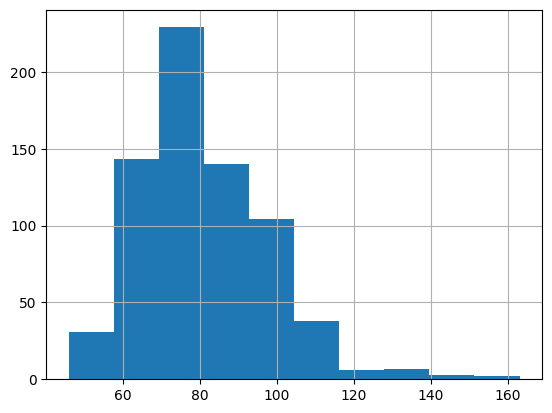

In [ ]:
df['sequence_length'].hist()

<Axes: xlabel='sequence_length'>

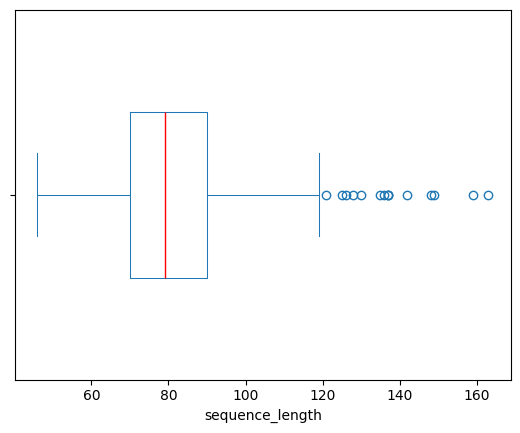

In [ ]:
sns.boxplot(
    x=df["sequence_length"], 
    fill=False, 
    gap=.1, 
    width=.5, 
    linecolor="#efefef", 
    linewidth=.75, 
    medianprops={"color": "r", "linewidth": 1},
    )

In [ ]:
# positive_sequences.extend([s[::-1] for s in positive_sequences])
# positive_sequences.extend(get_complementary_sequence(positive_sequences))

In [ ]:
num_sample_for_screening = 200
sampled_sequences_for_screening = random.sample(positive_sequences, num_sample_for_screening)

# Remove the sampled sequences from the original list
for seq in sampled_sequences_for_screening:
    positive_sequences.remove(seq)

mirnas_for_screening = []
for row in sampled_sequences_for_screening:
    # Create a dictionary for each row
    dictionary = {
        'sequence': row,
        'length': len(row)
    }
    # Append the dictionary to the list
    mirnas_for_screening.append(dictionary)

mirnas_for_screening[:2]

[{'sequence': 'CTGAAGAGTAGAGTGTGTGGTCCCAGTTCAGAAGTGTTCCTGAGTAACTTGTGCTTATAACTCAGGACACTTCTGAACTTGGACCATACAGGTCTCCCTGCTT',
  'length': 103},
 {'sequence': 'ACCTCCGGGACGGCTGGGCGCCGGCGGCCGGGAGATCCGCGCTTCCTGAATCCCGGCCGGCCCGCCCGGCGCCCGTCCGCCCGCGGGTC',
  'length': 89}]

In [ ]:
len(positive_sequences)

503

In [ ]:
# positive_sequences = pad_and_randomize_sequences(positive_sequences, multiplier=1)
# positive_sequences = list(dict.fromkeys(positive_sequences))

### Negative Samples

In [ ]:
df_negative_sources = pd.read_csv(f'{path}/data/negative_sequences_source.csv')
df_negative_sources

,Unnamed: 0,Sequence,Chromosome,Start,End,Strand,Length
0,0,TGATTTAAGAACCGCTTATTTAAATAAGTGGTGTTCAGGGTCAGAG...,1,65068434,65079508,1,11074
1,1,TATCTAGAATGTTTGAAGGAATTATATAACAAACACAATGGATCTA...,1,210429133,210435133,1,6000
2,2,CATTTCTACTGAAAAAACAAAAATTAGCCAGGTATGGTGGCACACG...,1,210529133,210538133,1,9000
3,3,CTGGGCCAGTGCTCAGGAGGCTCCGTGCCAGCTGGAACACCGGGAA...,10,1167000,1168500,1,1500
4,4,ACACACAGTCTCTGCACGATGAGACCCTGCACCCAACACACAGTCT...,11,1167000,1169000,1,2000
5,5,TCTGTGCTTATCTGTGTCGTTTCTCATCTGTTGTTAATACGCCACA...,12,1167000,1170000,1,3000
6,6,CTGAGGAAAATCACAGGAGGCAGGAATGTATACTGTTTGTTGGGAA...,13,99653059,99663059,1,10000
7,7,CCAGCAGGCAACAGGTGGCATCACTGCTGGCAGGTTTGTCTCCTGG...,2,99653059,99673059,1,20000


In [ ]:
negative_sequences_ensemble = []
substring_length = 164
for negative_sequence_ensemble in df_negative_sources['Sequence']:
    substrings = []
    for idx in range(0, len(negative_sequence_ensemble)-substring_length, 4):
        new_sequence = negative_sequence_ensemble[idx:idx+substring_length]
        substrings.append(new_sequence)
    negative_sequences_ensemble.extend(substrings)
len(negative_sequences_ensemble)

15323

In [ ]:
num_neg_sample_for_screening = 1000
neg_sampled_sequences_for_screening = random.sample(negative_sequences_ensemble, num_neg_sample_for_screening)

# Remove the sampled sequences from the original list
for seq in neg_sampled_sequences_for_screening:
    negative_sequences_ensemble.remove(seq)

In [ ]:
# negative_sequences_ensemble.extend([s[::-1] for s in negative_sequences_ensemble])
# negative_sequences_ensemble.extend(get_complementary_sequence(negative_sequences_ensemble))
random.shuffle(negative_sequences_ensemble)
negative_sequences_ensemble = negative_sequences_ensemble[:len(positive_sequences)]
len(negative_sequences_ensemble)

503

### Distribute Data

In [ ]:

# Step 1: Prepare labels
y_positive = np.ones(len(positive_sequences))
y_negative = np.zeros(len(negative_sequences_ensemble))

# Step 2: Combine sequences and labels (no augmentation yet!)
X = positive_sequences + negative_sequences_ensemble
y = np.append(y_positive, y_negative)

# Step 3: Split original (non-augmented) data into train/test/val
X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(X, y, test_size=0.2, random_state=47)
X_test_raw, X_val_raw, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=48)


# Prepare test and val (NO augmentation, multiplier=1)
X_test = pad_and_randomize_sequences(X_test_raw, multiplier=1)
X_val = pad_and_randomize_sequences(X_val_raw, multiplier=1)

# Optionally deduplicate test and val too
# X_test = list(dict.fromkeys(X_test))
# X_val = list(dict.fromkeys(X_val))


### Data Augmentation

In [ ]:

# Augment ONLY training sequences
X_train = pad_and_randomize_sequences(X_train_raw, multiplier=21)
X_train = list(dict.fromkeys(X_train))  # remove duplicates
y_train = np.repeat(y_train_raw, 21)  # replicate labels for each augmentation

## Modelo con Red Neuronal

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics.classification import BinaryPrecision, BinaryRecall, BinaryAccuracy, BinaryF1Score
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Instanciar métricas fuera de la función
precision = BinaryPrecision()
recall = BinaryRecall()
accuracy = BinaryAccuracy()
f1_score = BinaryF1Score()

def f1_score_custom(y_true, y_pred):
    p = precision(y_pred, y_true)
    r = recall(y_pred, y_true)
    return 2 * ((p * r) / (p + r + 1e-7))  # Para evitar división por cero

class NeuralNetwork(nn.Module):
    def __init__(self, input_size=128, neurons=[32, 4], activation=nn.ReLU, dropout=0.1, l2_val=0.001, l1_val=0.001):
        super(NeuralNetwork, self).__init__()
        layers = []
        prev_size = input_size
        
        for value in neurons:
            layers.append(nn.Linear(prev_size, value))
            layers.append(nn.BatchNorm1d(value))
            layers.append(activation())
            layers.append(nn.Dropout(dropout))
            prev_size = value
        
        layers.append(nn.Linear(prev_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.model(x))  # Salida para clasificación binaria

def get_optimizer(model, optimizer_name='adam', learning_rate=0.1):
    if optimizer_name == 'adam':
        return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)  # weight_decay equivale a L2 regularization
    elif optimizer_name == 'sgd':
        return optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001)
    else:
        raise ValueError("Optimizer not supported")

def plot_loss_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 5))
    
    # Gráfico de loss
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()

def plot_confusion_matrix(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            y_test_pred = model(X_test_batch).round()
            all_preds.append(y_test_pred.cpu())
            all_labels.append(y_test_batch.cpu())

    # Convert to full tensors
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    TN, FP, FN, TP = cm.ravel()

    TPR = TP / (TP + FN)  # Same as Recall
    TNR = TN / (TN + FP)  # True Negative Rate
    models_metrics['TPR']['nn'] = TPR
    models_metrics['TNR']['nn'] = TNR
    
    # Plotly Mint color palette (hex values)
    mint_palette = [
            '#e4f1e1', 
            '#b4d9cc', 
            '#89c0b6', 
            '#63a6a0', 
            '#448c8a', 
            # '#287274', 
            # '#0d585f'
        ]
    
    # Create custom colormap
    mint_cmap = LinearSegmentedColormap.from_list("plotly_mint", mint_palette)
    
    # Plot with mint palette
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap=mint_cmap,
        xticklabels=["Class 0", "Class 1"], 
        yticklabels=["Class 0", "Class 1"],
        linewidths=.5,
        linecolor='lightgray',
        annot_kws={"size": 12}  # Annotation styling
    )

    # Styling
    plt.xlabel("Predicted", fontsize=12, labelpad=10)
    plt.ylabel("Actual", fontsize=12, labelpad=10)
    #plt.title("Confusion Matrix", fontsize=14, pad=15)
    
    # Add border
    for _, spine in plt.gca().spines.items():
        spine.set_visible(True)
        spine.set_edgecolor('gray')
        spine.set_linewidth(0.5)
    
    # Adjust colorbar
    cbar = plt.gcf().axes[-1]
    cbar.tick_params(labelsize=10)
    
    plt.tight_layout()
    plt.show()

def classification_metrics(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            y_test_pred = model(X_test_batch).round()
            all_preds.append(y_test_pred.cpu())
            all_labels.append(y_test_batch.cpu())
    
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    report = classification_report(all_labels, all_preds, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)


## MiRNA2Vec

In [ ]:
class MiRNA2Vec:
    def __init__(self, k_mers: int = 3, vector_size: int = 100, epochs: int = 5, skip_gram = 1, min_count = 1, hs = 1, min_alpha=0.01):
        self.__model = None
        self.k_mers = k_mers
        self.vector_size = vector_size
        self.epochs = epochs
        self.window = 5
        self.min_count = min_count
        self.workers = 8
        self.skip_gram = skip_gram
        self.hs = hs
        self.min_alpha = min_alpha

    @property
    def model(self):
        return self.__model

    def __get_tokens(self, sequence):
        return [sequence[i:i + self.k_mers] for i in range(len(sequence) - self.k_mers + 1)]

    def tokenize_sequences(self, sequences):
        """Tokenize sequences into k-mers."""
        tokenized_sequences = []
        for seq in sequences:
            tokens = self.__get_tokens(seq)
            tokenized_sequences.append(tokens)
        return tokenized_sequences

    def train_word2vec(self, tokenized_sequences):
        """Train Word2Vec model on tokenized sequences."""
        self.__model = Word2Vec(sentences=tokenized_sequences,
                                vector_size=self.vector_size,
                                window=self.window,
                                min_count=self.min_count,
                                workers=self.workers,
                                epochs=self.epochs,
                                sg=self.skip_gram,
                                hs=self.hs,
                                min_alpha=self.min_alpha)
        return self.__model

    def get_average_embeddings(self, sequences):
        """Get average embedding for each sequence."""
        embeddings = []
        for seq in sequences:
            tokens = self.__get_tokens(seq)
            token_embeddings = [self.model.wv[token] for token in tokens if token in self.model.wv]
            if token_embeddings:
                avg_embedding = np.mean(token_embeddings, axis=0)
            else:
                avg_embedding = np.zeros(self.model.vector_size)
            embeddings.append(avg_embedding.tolist())
        return np.array(embeddings)

    def get_median_embeddings(self, sequences):
        """Get median embedding for each sequence."""
        embeddings = []
        for seq in sequences:
            tokens = self.__get_tokens(seq)
            token_embeddings = [self.model.wv[token] for token in tokens if token in self.model.wv]
            if token_embeddings:
                median_embedding = np.median(token_embeddings, axis=0)
            else:
                median_embedding = np.zeros(self.model.vector_size)
            embeddings.append(median_embedding.tolist())
        return np.array(embeddings)


    def load_model(self, path, tokenized_sequences):
        self.__model = Word2Vec(sentences=tokenized_sequences,
                                vector_size=self.vector_size,
                                window=self.window,
                                min_count=self.min_count,
                                workers=self.workers,
                                epochs=self.epochs)
        self.__model.wv = KeyedVectors.load_word2vec_format(path,
                                          binary=False)  # Change binary to False if the model is in text format
        # Continue training the Word2Vec model with your new sequences
        self.__model.build_vocab(tokenized_sequences, update=True)  # Update the vocabulary with new sentences
        self.__model.train(tokenized_sequences, total_examples=self.__model.corpus_count, epochs=self.__model.epochs)
        return self.__model


In [ ]:
# Create miRNA2Vec instance
miRNA2Vec = MiRNA2Vec(
    k_mers=5, 
    vector_size=128, 
    epochs=20,
    skip_gram=0,
    min_count=5,
    hs=1,
    min_alpha=0.001
)
# Create the dataset for Word2Vec
tokenized_sequences = miRNA2Vec.tokenize_sequences(X_train)
# Train the Word2Vec model
miRNA2Vec.train_word2vec(tokenized_sequences)


In [ ]:
vocab = get_vocab(miRNA2Vec.k_mers)
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=miRNA2Vec.model.wv.get_vector(word)
len(vocab)

1024

In [ ]:
# Crear un diccionario para mapear cada k-mer a un índice
mer_to_index = {mer: i+1 for i, mer in enumerate(miRNA2Vec.model.wv.index_to_key)}
index_to_mer = {i+1: mer for i, mer in enumerate(miRNA2Vec.model.wv.index_to_key)}

indexed_sequences_train = [sequence_to_indices(seq, mer_to_index) for seq in tokenized_sequences]
tokenized_sequences_test = miRNA2Vec.tokenize_sequences(X_test)

indexed_sequences_test = [sequence_to_indices(seq, mer_to_index) for seq in tokenized_sequences_test]

# Padding para asegurar que todas las secuencias tengan la misma longitud
max_seq_len_test = max(len(seq) for seq in indexed_sequences_test)

tokenized_sequences_val = miRNA2Vec.tokenize_sequences(X_val)

indexed_sequences_val = [sequence_to_indices(seq, mer_to_index) for seq in tokenized_sequences_val]

# Padding para asegurar que todas las secuencias tengan la misma longitud
max_seq_len_val = max(len(seq) for seq in indexed_sequences_val)

# Padding para asegurar que todas las secuencias tengan la misma longitud
max_seq_len_train = max(len(seq) for seq in indexed_sequences_train)
max_seq_len = max(max_seq_len_train, max_seq_len_test, max_seq_len_val)
X_train_pad_sequences = pad_sequences(indexed_sequences_train, maxlen=max_seq_len, padding='post')
X_test_pad_sequences = pad_sequences(indexed_sequences_test, maxlen=max_seq_len, padding='post')
X_val_pad_sequences = pad_sequences(indexed_sequences_val, maxlen=max_seq_len, padding='post')

X_train_pad_sequences.shape

(804, 160)

In [ ]:
X_val_pad_sequences.shape

(101, 160)

In [ ]:
X_train_pad_sequences.shape

(804, 160)

In [ ]:
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_median_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_median_embeddings(X_test)
X_val_mirna2vec = miRNA2Vec.get_median_embeddings(X_val)

### training NN model

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_mirna2vec, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_mirna2vec, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_mirna2vec, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create PyTorch datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Instantiate model
model_nn = NeuralNetwork(input_size=128)

# Define optimizer and loss function
optimizer = get_optimizer(model_nn, optimizer_name='adam', learning_rate=0.01)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train_model_nn(model, train_loader, val_loader, criterion, optimizer, epochs=10, device='cpu'):
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                y_val_pred = model(X_val_batch)
                val_loss += criterion(y_val_pred, y_val_batch).item()

        val_losses.append(val_loss / len(val_loader))
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

# Entrenar el modelo y guardar las pérdidas
train_losses, val_losses = train_model_nn(model_nn, train_loader, val_loader, criterion, optimizer, epochs=40)




Epoch 1/40 - Train Loss: 0.5501 - Val Loss: 0.4288
Epoch 2/40 - Train Loss: 0.3865 - Val Loss: 0.2981
Epoch 3/40 - Train Loss: 0.3027 - Val Loss: 0.2879
Epoch 4/40 - Train Loss: 0.2454 - Val Loss: 0.2577
Epoch 5/40 - Train Loss: 0.2351 - Val Loss: 0.2689
Epoch 6/40 - Train Loss: 0.2124 - Val Loss: 0.2616
Epoch 7/40 - Train Loss: 0.1933 - Val Loss: 0.2064
Epoch 8/40 - Train Loss: 0.1808 - Val Loss: 0.2087
Epoch 9/40 - Train Loss: 0.2050 - Val Loss: 0.2614
Epoch 10/40 - Train Loss: 0.1904 - Val Loss: 0.2492
Epoch 11/40 - Train Loss: 0.1494 - Val Loss: 0.2543
Epoch 12/40 - Train Loss: 0.1529 - Val Loss: 0.2523
Epoch 13/40 - Train Loss: 0.1578 - Val Loss: 0.1945
Epoch 14/40 - Train Loss: 0.1845 - Val Loss: 0.2622
Epoch 15/40 - Train Loss: 0.1219 - Val Loss: 0.2423
Epoch 16/40 - Train Loss: 0.1181 - Val Loss: 0.2988
Epoch 17/40 - Train Loss: 0.1747 - Val Loss: 0.3272
Epoch 18/40 - Train Loss: 0.2489 - Val Loss: 0.3207
Epoch 19/40 - Train Loss: 0.1517 - Val Loss: 0.2801
Epoch 20/40 - Train L

Epoch 27/40 - Train Loss: 0.1736 - Val Loss: 0.2746
Epoch 28/40 - Train Loss: 0.1329 - Val Loss: 0.2885
Epoch 29/40 - Train Loss: 0.1366 - Val Loss: 0.2555
Epoch 30/40 - Train Loss: 0.1139 - Val Loss: 0.2549
Epoch 31/40 - Train Loss: 0.1159 - Val Loss: 0.3050
Epoch 32/40 - Train Loss: 0.1050 - Val Loss: 0.3185
Epoch 33/40 - Train Loss: 0.0940 - Val Loss: 0.2988
Epoch 34/40 - Train Loss: 0.1098 - Val Loss: 0.3522
Epoch 35/40 - Train Loss: 0.1062 - Val Loss: 0.2586
Epoch 36/40 - Train Loss: 0.0899 - Val Loss: 0.2667
Epoch 37/40 - Train Loss: 0.0966 - Val Loss: 0.2428
Epoch 38/40 - Train Loss: 0.0867 - Val Loss: 0.2614
Epoch 39/40 - Train Loss: 0.1114 - Val Loss: 0.3049
Epoch 40/40 - Train Loss: 0.1747 - Val Loss: 0.2183


In [ ]:
from torchmetrics.classification import BinaryAccuracy

accuracy_metric = BinaryAccuracy()

model_nn.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        y_test_pred = model_nn(X_test_batch).round()
        all_preds.append(y_test_pred)
        all_labels.append(y_test_batch)

# Calcular precisión
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
accuracy = accuracy_metric(all_preds, all_labels)
print(f"Test Accuracy: {accuracy.item():.4f}")


Test Accuracy: 0.8812


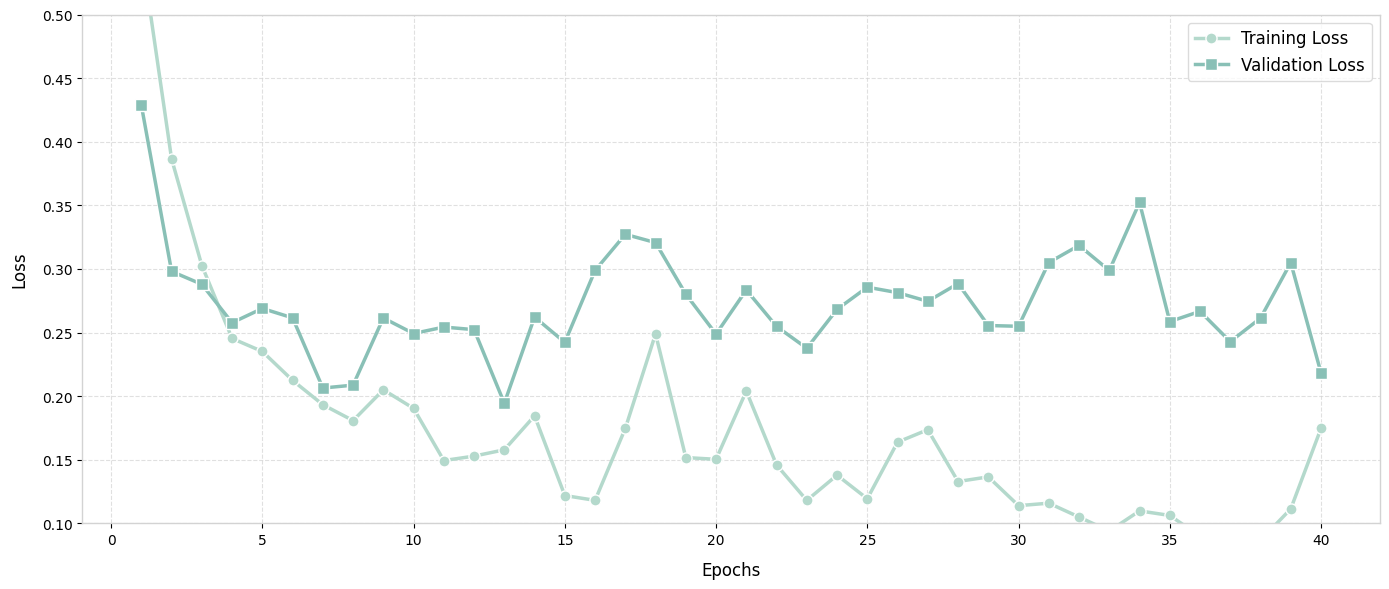

In [ ]:
def plot_loss_curve(train_losses, val_losses, ymin=None, ymax=None):
    """Plot training and validation loss curves with mint color scheme.
    
    Args:
        train_losses (list): Training loss values per epoch
        val_losses (list): Validation loss values per epoch
        ymin (float): Minimum value for y-axis (None for auto)
        ymax (float): Maximum value for y-axis (None for auto)
    """
    # Plotly Mint color palette (hex values)
    mint_palette = [
            '#e4f1e1', 
            '#b4d9cc', 
            '#89c0b6', 
            '#63a6a0', 
            '#448c8a', 
            '#287274', 
            '#0d585f'
        ]

    # Create figure with white background
    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.set_facecolor('white')  # White background
    
    epochs = range(1, len(train_losses) + 1)
    
    # Plot with mint colors
    plt.plot(epochs, train_losses, 
             label='Training Loss', 
             color=mint_palette[1], 
             linewidth=2.5,
             marker='o',
             markersize=8,
             markeredgecolor='white',
             markerfacecolor=mint_palette[1])
    
    plt.plot(epochs, val_losses, 
             label='Validation Loss', 
             color=mint_palette[2], 
             linewidth=2.5,
             marker='s',
             markersize=8,
             markeredgecolor='white',
             markerfacecolor=mint_palette[2])
    
    # Set y-axis limits
    if ymin is not None or ymax is not None:
        current_ymin, current_ymax = ax.get_ylim()
        new_ymin = ymin if ymin is not None else current_ymin
        new_ymax = ymax if ymax is not None else current_ymax
        plt.ylim(new_ymin, new_ymax)
    else:
        # Auto-scale with 5% padding if no limits specified
        all_losses = train_losses + val_losses
        y_padding = 0.05 * (max(all_losses) - min(all_losses))
        plt.ylim(min(all_losses) - y_padding, max(all_losses) + y_padding)
    
    # Styling
    plt.xlabel('Epochs', fontsize=12, labelpad=10)
    plt.ylabel('Loss', fontsize=12, labelpad=10)
    #plt.title('Training and Validation Loss', fontsize=14, pad=15)
    
    # Custom legend
    legend = plt.legend(fontsize=12, frameon=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('lightgray')
    
    # Grid and borders
    plt.grid(True, linestyle='--', alpha=0.7, color='lightgray')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('lightgray')
        spine.set_linewidth(1)
    
    # Adjust ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.tight_layout()
    plt.show()

plot_loss_curve(train_losses, val_losses, ymin=0.1, ymax=0.5)

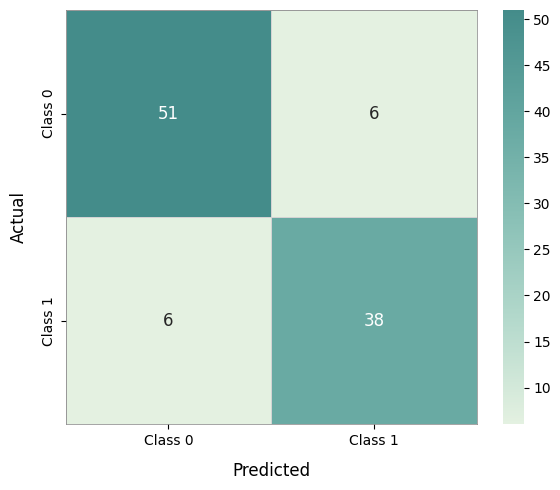

In [ ]:
# Generar la matriz de confusión
plot_confusion_matrix(model_nn, test_loader)


In [ ]:
classification_metrics(model_nn, test_loader)

              precision    recall  f1-score     support
0.0            0.894737  0.894737  0.894737   57.000000
1.0            0.863636  0.863636  0.863636   44.000000
accuracy       0.881188  0.881188  0.881188    0.881188
macro avg      0.879187  0.879187  0.879187  101.000000
weighted avg   0.881188  0.881188  0.881188  101.000000


In [ ]:
update_models_metrics('nn', model_nn, test_loader, models_metrics)
print(models_metrics)

{'precision': {'nn_negative': 0.8947368421052632, 'nn_positive': 0.8636363636363636}, 'recall': {'nn_negative': 0.8947368421052632, 'nn_positive': 0.8636363636363636}, 'f1': {}, 'TPR': {'nn': 0.8636363636363636}, 'TNR': {'nn': 0.8947368421052632}, 'probs_list': {}, 'f1-score': {'nn_negative': 0.8947368421052632, 'nn_positive': 0.8636363636363636}, 'predictions': {'nn': [[1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0

## SVC


In [ ]:
num_samples = 1000
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_median_embeddings(X_train)[:num_samples]
X_test_mirna2vec = miRNA2Vec.get_median_embeddings(X_test)
# Train SVM
svm_model = SVC(kernel='rbf', class_weight=None, C=10, probability=True, gamma='scale')
svm_model.fit(X_train_mirna2vec, y_train[:num_samples])
# Predict and evaluate
y_pred = svm_model.predict(X_test_mirna2vec)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score_sklearn(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
TN, FP, FN, TP = cm.ravel()

TPR = TP / (TP + FN)  # Same as Recall
TNR = TN / (TN + FP)  # True Negative Rate
models_metrics['TPR']['svc'] = TPR
models_metrics['TNR']['svc'] = TNR
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 95.05%
Precision: 93.33%
Recall: 95.45%
F1: 94.38%
Confusion Matrix:
[[54  3]
 [ 2 42]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96        57
         1.0       0.93      0.95      0.94        44

    accuracy                           0.95       101
   macro avg       0.95      0.95      0.95       101
weighted avg       0.95      0.95      0.95       101



In [ ]:
# Asegúrate de inicializar el dict si aún no existe
models_metrics = models_metrics if 'models_metrics' in locals() else {'precision': {}, 'recall': {}, 'f1': {}, 'predictions': {}}

# Guardar métricas individuales
models_metrics['precision']['svc_positive'] = precision_score(y_test, y_pred, pos_label=1)
models_metrics['precision']['svc_negative'] = precision_score(y_test, y_pred, pos_label=0)

models_metrics['recall']['svc_positive'] = recall_score(y_test, y_pred, pos_label=1)
models_metrics['recall']['svc_negative'] = recall_score(y_test, y_pred, pos_label=0)

models_metrics['f1']['svc_positive'] = f1_score_sklearn(y_test, y_pred, pos_label=1)
models_metrics['f1']['svc_negative'] = f1_score_sklearn(y_test, y_pred, pos_label=0)

# Guardar predicciones (como lista plana)
models_metrics['predictions']['svc'] = y_pred.tolist()


## RF

In [ ]:
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_median_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_median_embeddings(X_test)
# Train RF
rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        min_samples_split=2,
        class_weight=None,
        max_features='sqrt',
        random_state=42
    )
rf_model.fit(X_train_mirna2vec, y_train)
# Predict and evaluate
y_pred = rf_model.predict(X_test_mirna2vec)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score_sklearn(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
TN, FP, FN, TP = cm.ravel()

TPR = TP / (TP + FN)  # Same as Recall
TNR = TN / (TN + FP)  # True Negative Rate
models_metrics['TPR']['rf'] = TPR
models_metrics['TNR']['rf'] = TNR
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 92.08%
Precision: 89.13%
Recall: 93.18%
F1: 91.11%
Confusion Matrix:
[[52  5]
 [ 3 41]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93        57
         1.0       0.89      0.93      0.91        44

    accuracy                           0.92       101
   macro avg       0.92      0.92      0.92       101
weighted avg       0.92      0.92      0.92       101



In [ ]:

# Guardar métricas individuales
models_metrics['precision']['rf_positive'] = precision_score(y_test, y_pred, pos_label=1)
models_metrics['precision']['rf_negative'] = precision_score(y_test, y_pred, pos_label=0)

models_metrics['recall']['rf_positive'] = recall_score(y_test, y_pred, pos_label=1)
models_metrics['recall']['rf_negative'] = recall_score(y_test, y_pred, pos_label=0)

models_metrics['f1']['rf_positive'] = f1_score_sklearn(y_test, y_pred, pos_label=1)
models_metrics['f1']['rf_negative'] = f1_score_sklearn(y_test, y_pred, pos_label=0)

# Guardar predicciones (como lista plana)
models_metrics['predictions']['rf'] = y_pred.tolist()


In [ ]:
models_metrics

{'precision': {'nn_negative': 0.8947368421052632,
  'nn_positive': 0.8636363636363636,
  'svc_positive': 0.9333333333333333,
  'svc_negative': 0.9642857142857143,
  'rf_positive': 0.8913043478260869,
  'rf_negative': 0.9454545454545454},
 'recall': {'nn_negative': 0.8947368421052632,
  'nn_positive': 0.8636363636363636,
  'svc_positive': 0.9545454545454546,
  'svc_negative': 0.9473684210526315,
  'rf_positive': 0.9318181818181818,
  'rf_negative': 0.9122807017543859},
 'f1': {'svc_positive': 0.9438202247191011,
  'svc_negative': 0.9557522123893806,
  'rf_positive': 0.9111111111111111,
  'rf_negative': 0.9285714285714286},
 'TPR': {'nn': 0.8636363636363636,
  'svc': 0.9545454545454546,
  'rf': 0.9318181818181818},
 'TNR': {'nn': 0.8947368421052632,
  'svc': 0.9473684210526315,
  'rf': 0.9122807017543859},
 'probs_list': {},
 'f1-score': {'nn_negative': 0.8947368421052632,
  'nn_positive': 0.8636363636363636},
 'predictions': {'nn': [[1.0],
   [0.0],
   [0.0],
   [1.0],
   [1.0],
   [0.0

# Screening

In [ ]:
class Screening:

    def __init__(self, positive_sequences=[], negative_sequences=[], mirna_gap = 500, screen_size = 85):
        self.df = None
        self.list_of_positions_of_positive_samples = []
        self.mirna_gap = mirna_gap
        self.positive_sequences = positive_sequences
        self.negative_sequences = negative_sequences
        self.positive_map = {0: []}
        self.negative_map = {}
        self.positive_seq_positions = []
        self.results = []
        self.runtime = None
        self.nt_per_second = None
        self.screen_size = screen_size
        self.sequence_for_screening = ''
        self.metrics_df = pd.DataFrame(columns=["model_name", "threshold", "TPR", "TNR", "GMeans"])
        for seq in positive_sequences:
            if self.positive_map.get(len(seq)):
                self.positive_map[len(seq)].append(seq)
            else:
                self.positive_map[len(seq)] = []
                self.positive_map[len(seq)].append(seq)
        for seq in negative_sequences:
            if self.negative_map.get(len(seq)):
                self.negative_map[len(seq)].append(seq)
            else:
                self.negative_map[len(seq)] = []
                self.negative_map[len(seq)].append(seq)
        self.nt_with_most_data = 0
        for nt in self.positive_map.keys():
            if len(self.positive_map[nt]) > len(self.positive_map[self.nt_with_most_data]):
                self.nt_with_most_data = nt

    def calculate_recall(self, probabilities, threshold=0.5):
        """
        Calculate Recall based on detected and expected peaks.

        Parameters:
            probabilities (list or np.ndarray): Probabilities for each position.
            threshold (float): Threshold for detecting positive samples from probabilities.

        Returns:
            float: Recall metric.
        """
        detected_indices = np.where(np.array(probabilities) > threshold)[0]

        # Group detected indices into contiguous regions (detected peaks)
        detected_peaks = []
        if len(detected_indices) > 0:
            current_peak = [detected_indices[0], detected_indices[0]]
            for idx in detected_indices[1:]:
                if idx == current_peak[1] + 1:
                    current_peak[1] = idx
                else:
                    detected_peaks.append({'start': current_peak[0], 'end': current_peak[1]})
                    current_peak = [idx, idx]
            detected_peaks.append({'start': current_peak[0], 'end': current_peak[1]})

        true_positives = 0
        false_negatives = 0

        used_ground_truth = set()

        for detected in detected_peaks:
            for i, expected in enumerate(self.positive_seq_positions):
                if i not in used_ground_truth:
                    if not (detected['end'] < expected['start'] or detected['start'] > expected['end']):
                        true_positives += 1
                        used_ground_truth.add(i)
                        break

        false_negatives = len(self.positive_seq_positions) - len(used_ground_truth)

        recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0.0
        return recall

    def calculate_iou(self, probabilities, threshold=0.5):
        """
        Calculate Intersection over Union (IoU) based on probabilities and ground truth regions.

        Parameters:
            probabilities (list or np.ndarray): Probabilities for each position.
            threshold (float): Threshold for detecting positive samples from probabilities.

        Returns:
            float: IoU metric.
        """
        detected = np.where(np.array(probabilities) > threshold, 1, 0)

        detected_set = set(np.where(detected == 1)[0])  # Indices of detected positives
        ground_truth_set = set()
        for region in self.positive_seq_positions:
            ground_truth_set.update(range(region['start'], region['end']))

        intersection = detected_set & ground_truth_set
        union = detected_set | ground_truth_set
        iou = len(intersection) / len(union) if union else 0.0

        return iou

    def calculate_precision(self, probabilities, threshold=0.5):
        """
        Calculate Precision based on detected and expected peaks.
        One detected region can match at most one expected region (no multiple TPs per region).

        Parameters:
            probabilities (list or np.ndarray): Probabilities for each position.
            threshold (float): Threshold for detecting positive samples from probabilities.

        Returns:
            float: Precision metric.
        """
        detected_indices = np.where(np.array(probabilities) > threshold)[0]

        # Group detected indices into contiguous regions (detected peaks)
        detected_peaks = []
        if len(detected_indices) > 0:
            current_peak = [detected_indices[0], detected_indices[0]]
            for idx in detected_indices[1:]:
                if idx == current_peak[1] + 1:
                    current_peak[1] = idx
                else:
                    detected_peaks.append({'start': current_peak[0], 'end': current_peak[1]})
                    current_peak = [idx, idx]
            detected_peaks.append({'start': current_peak[0], 'end': current_peak[1]})

        true_positives = 0
        false_positives = 0

        # Marcar regiones positivas ya detectadas
        matched_expected = set()

        for detected in detected_peaks:
            intersected = False
            for i, expected in enumerate(self.positive_seq_positions):
                if i in matched_expected:
                    continue  # Esta región ya fue usada

                if not (detected['end'] < expected['start'] or detected['start'] > expected['end']):
                    intersected = True
                    true_positives += 1
                    matched_expected.add(i)
                    break

            if not intersected:
                false_positives += 1

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
        return precision


    def calculate_accuracy(self, probabilities, threshold=0.5):
        """
        Calculate Accuracy based on detected and expected peaks.

        Parameters:
            probabilities (list or np.ndarray): Probabilities for each position.
            threshold (float): Threshold for detecting positive samples from probabilities.

        Returns:
            float: Accuracy metric.
        """
        detected_indices = np.where(np.array(probabilities) > threshold)[0]

        # Group detected indices into contiguous regions (detected peaks)
        detected_peaks = []
        if len(detected_indices) > 0:
            current_peak = [detected_indices[0], detected_indices[0]]
            for idx in detected_indices[1:]:
                if idx == current_peak[1] + 1:
                    current_peak[1] = idx
                else:
                    detected_peaks.append({'start': current_peak[0], 'end': current_peak[1]})
                    current_peak = [idx, idx]
            detected_peaks.append({'start': current_peak[0], 'end': current_peak[1]})

        true_positives = 0
        false_positives = 0
        used_ground_truth = set()

        for detected in detected_peaks:
            matched = False
            for i, expected in enumerate(self.positive_seq_positions):
                if i not in used_ground_truth:
                    if not (detected['end'] < expected['start'] or detected['start'] > expected['end']):
                        true_positives += 1
                        used_ground_truth.add(i)
                        matched = True
                        break
            if not matched:
                false_positives += 1

        false_negatives = len(self.positive_seq_positions) - len(used_ground_truth)

        accuracy = true_positives / (true_positives + false_positives + false_negatives) if (true_positives + false_positives + false_negatives) > 0 else 0.0
        return accuracy
  
    def generate_sequence_for_screening(self, debug=False, pos_seq_for_debug=[], neg_seq_for_debug=[], num_of_negatives=1):
        def get_fixed_length_neg_sample(negative_samples, target_length):
            """Generate a negative sample of exact target_length by concatenating elements if necessary."""
            neg_seq = ""
            while len(neg_seq) < target_length:
                neg_seq += random.choice(negative_samples)

            return neg_seq[:target_length]  # Ensure exact length

        premir_positions= []
        if debug == True:
            self.sequence_for_screening = '' + neg_seq_for_debug[0]
            for idx in range(pos_seq_for_debug.__len__()):
                premir_positions.append({
                    'start': len(self.sequence_for_screening),
                    'end': len(self.sequence_for_screening) + pos_seq_for_debug[idx].__len__()
                })
                self.sequence_for_screening += pos_seq_for_debug[idx] 
                for neg_idx in range(num_of_negatives):
                    self.sequence_for_screening +=  neg_seq_for_debug[idx+neg_idx+1]
            self.positive_seq_positions = premir_positions
            return
        
        sequence_for_screening = get_fixed_length_neg_sample(self.negative_sequences, self.mirna_gap)  # Start with a valid negative sample
        premir_positions = []

        for mirna_seq in self.positive_sequences:
            neg_seq = get_fixed_length_neg_sample(self.negative_sequences, self.mirna_gap)

            premir_positions.append({
                'start': len(sequence_for_screening),
                'end': len(sequence_for_screening) + len(mirna_seq['sequence'])
            })
            
            sequence_for_screening += mirna_seq['sequence'] + neg_seq

        self.sequence_for_screening = sequence_for_screening
        self.positive_seq_positions = premir_positions

    def apply_smoothing(self, smooth_size=200, smooth_type="mean"):
        """ Applies the selected smoothing technique to the results. """
        if smooth_type is None:
            return
        if self.df is None:
            raise ValueError("No results available. Run get_results_with_word2vec_nn_and_batches first.")

        col_name = f'y_ws_{smooth_size}_{smooth_type}'
        y_series = self.df['y']

        smoothing_methods = {
            "mean": lambda: y_series.rolling(window=smooth_size, center=True).mean(),
            "median": lambda: y_series.rolling(window=smooth_size, center=True).median(),
            "max": lambda: y_series.rolling(window=smooth_size, center=True).max(),
            "gaussian": lambda: gaussian_filter1d(y_series, sigma=smooth_size / 2),
            "ema": lambda: y_series.ewm(span=smooth_size, adjust=False).mean(),
            "savgol": lambda: savgol_filter(y_series, window_length=smooth_size, polyorder=2, mode='nearest'),
            "hamming": lambda: np.convolve(y_series, np.hamming(smooth_size) / np.hamming(smooth_size).sum(), mode='same'),
            "triangular": lambda: np.convolve(y_series, np.bartlett(smooth_size) / np.bartlett(smooth_size).sum(), mode='same'),
            "butterworth": lambda: filtfilt(*butter(N=2, Wn=0.1), y_series)
        }

        if smooth_type in smoothing_methods:
            self.df[col_name] = smoothing_methods[smooth_type]()
        else:
            raise ValueError(f"Unknown smoothing type: {smooth_type}")

    def get_results_with_word2vec_and_nn(self, word2vec, model, smooth_size=200, smooth_type="mean", batch_size=512):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        start = time.time()

        # Precompute tokenized and indexed sequences
        print("Generating sequences for screening...")
        all_sequences = [
            self.sequence_for_screening[idx:idx + self.screen_size]
            for idx in range(0, len(self.sequence_for_screening) - self.screen_size)
        ]
        print(f"Calculating embeddings for {len(all_sequences)} sequences...")
        embeddings = word2vec.get_median_embeddings(all_sequences)
        # Convert embeddings to tensor
        model.to(device)
        model.eval()
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32, device=device)

        # Perform batch prediction
        predictions = [np.nan for i in range(self.screen_size // 2)]
        with torch.no_grad():
            for i in range(0, len(embeddings_tensor), batch_size):
                batch = embeddings_tensor[i:i + batch_size]
                batch_pred = model(batch).cpu().numpy()  # Move to CPU for NumPy processing
                predictions.extend(batch_pred[:, 0].tolist())

        self.results = predictions
        # Crear un DataFrame a partir de los datos
        self.df = pd.DataFrame({'x': range(len(self.results)), 'y': self.results})

        self.apply_smoothing(smooth_size, smooth_type)
        end = time.time()
        self.runtime = end - start
        self.nt_per_second = self.sequence_for_screening.__len__() / self.runtime
        print(f"time executed: {self.runtime} seconds")
        return self.results

    def get_results_with_word2vec_and_model_1(self, model, smooth_size=200, smooth_type="mean", batch_size=8):
        import torch
        import time
        import numpy as np
        import pandas as pd

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model.eval()

        self.results = [np.nan for i in range(self.screen_size // 2)]
        start = time.time()
        inputs_batch = []

        for idx in range(0, len(self.sequence_for_screening) - self.screen_size):
            new_sequence = self.sequence_for_screening[idx:idx + self.screen_size]
            new_sequence = convert_DNA_sequence_to_RNA(new_sequence)

            fc = RNA.fold_compound(new_sequence)
            (ss, mfe) = fc.mfe()

            # One-hot encode the sequence
            one_hot = one_hot_encode_sequence(new_sequence)

            # Convert pairing matrix to L × L × 1
            pairing_matrix_expanded = np.expand_dims(dot_bracket_to_pairing_matrix(ss), axis=2)

            concatenated_matrix = np.concatenate(
                (pairing_matrix_expanded,
                reshape_and_replicate_horizontally(one_hot),
                reshape_and_replicate_vertically(one_hot)),
                axis=2)

            padded_matrix = pad_matrix_to_fixed_size(concatenated_matrix, target_shape)

            inputs_batch.append(padded_matrix)

            # Process in batches
            if len(inputs_batch) == batch_size or idx == len(self.sequence_for_screening) - self.screen_size - 1:
                batch_tensor = torch.tensor(inputs_batch, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
                with torch.no_grad():
                    outputs = model(batch_tensor)
                    probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1
                    self.results.extend(probs.cpu().numpy())
                inputs_batch = []

        # Crear DataFrame
        self.df = pd.DataFrame({'x': range(len(self.results)), 'y': self.results})

        self.apply_smoothing(smooth_size, smooth_type)

        end = time.time()
        self.runtime = end - start
        self.nt_per_second = len(self.sequence_for_screening) / self.runtime
        print(f"time executed: {self.runtime} seconds")

        return self.results

    def get_results_with_model_2(self, model, smooth_size=200, smooth_type="mean", batch_size=16):
        start = time.time()
    
        # Generate subsequences for screening
        seqs_to_screening = [self.sequence_for_screening[idx:idx+self.screen_size] 
                            for idx in range(len(self.sequence_for_screening) - self.screen_size)]
        
        # Convert sequences to one-hot encoding
        seqs_to_screening_one_hot = preprocess_dna_sequences(seqs_to_screening, 164)

        # Convert to PyTorch tensor and move to device (CPU/GPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        input_tensor = torch.tensor(seqs_to_screening_one_hot, dtype=torch.float32).to(device)
        
        # Store predictions
        results = [np.nan for i in range(self.screen_size // 2)]

        # Perform batched inference to prevent memory issues
        model.eval()
        with torch.no_grad():
            for i in range(0, len(input_tensor), batch_size):
                batch = input_tensor[i:i+batch_size]
                outputs = model(batch)
                probs = torch.softmax(outputs, dim=1)[:, 1]  # Extract probability of class 1
                results.extend(probs.cpu().numpy())  # Move to CPU before storing

        # Save results in DataFrame
        self.results = results

        # Crear un DataFrame a partir de los datos
        self.df = pd.DataFrame({'x': range(len(self.results)), 'y': self.results})

        self.apply_smoothing(smooth_size, smooth_type)
        end = time.time()
        self.runtime = end - start
        self.nt_per_second = self.sequence_for_screening.__len__() / self.runtime
        print(f"time executed: {self.runtime} seconds")
        return self.results

    def get_results_with_word2vec_and_svc(self, word2vec, svc, smooth_size=200, smooth_type="mean", batch_size=16):
        self.results = [np.nan for i in range(self.screen_size // 2)]
        start = time.time()
        sequence_list = [self.sequence_for_screening[idx:idx+self.screen_size] 
                     for idx in range(len(self.sequence_for_screening) - self.screen_size)]
    
        # Convert sequences into embeddings using word2vec
        embeddings = word2vec.get_median_embeddings(sequence_list)  # Shape: (N, 128)

        # Convert embeddings to PyTorch tensor and move to device (CPU/GPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32).to(device)

        # Perform batched inference with SVC (it runs on CPU)
        with torch.no_grad():
            for i in range(0, len(embeddings_tensor), batch_size):
                batch = embeddings_tensor[i:i+batch_size].cpu().numpy()  # Move to CPU for sklearn
                batch_probs = svc.predict_proba(batch)[:, 1]  # Get probability of class 1
                self.results.extend(batch_probs)

        # Crear un DataFrame a partir de los datos
        self.df = pd.DataFrame({'x': range(len(self.results)), 'y': self.results})

        self.apply_smoothing(smooth_size, smooth_type)
        end = time.time()
        self.runtime = end - start
        self.nt_per_second = self.sequence_for_screening.__len__() / self.runtime
        print(f"time executed: {self.runtime} seconds")
        return self.results
    
    def get_results_with_word2vec_and_rf(self, word2vec, rf_model, smooth_size=200, smooth_type="mean", batch_size=16):
        start_time = time.time()
        sequence_list = [self.sequence_for_screening[idx:idx+self.screen_size] 
                        for idx in range(len(self.sequence_for_screening) - self.screen_size)]
        
        # Convert sequences into embeddings using word2vec
        embeddings = word2vec.get_median_embeddings(sequence_list)  # Shape: (N, 128)

        # Convert embeddings to PyTorch tensor and move to device (CPU/GPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32).to(device)

        # Store predictions
        self.results = [np.nan for i in range(self.screen_size // 2)]

        # Perform batched inference with Random Forest (it runs on CPU)
        with torch.no_grad():
            for i in range(0, len(embeddings_tensor), batch_size):
                batch = embeddings_tensor[i:i+batch_size].cpu().numpy()  # Move to CPU for sklearn
                batch_probs = rf_model.predict_proba(batch)[:, 1]  # Get probability of class 1
                self.results.extend(batch_probs)

        # Save results in DataFrame
        self.df = pd.DataFrame({'x': range(len(self.results)), 'y': self.results})

        # Apply smoothing
        self.apply_smoothing(smooth_size, smooth_type)

        # Measure execution time
        self.runtime = time.time() - start_time
        self.nt_per_second = self.sequence_for_screening.__len__() / self.runtime
        print(f"Execution time: {self.runtime:.2f} seconds")

        return self.results

    def get_map_nt_number_of_sequence(self):
        map_to_return = {}
        for nt in self.positive_map.keys():
            map_to_return[nt] = len(self.positive_map.get(nt))
        return map_to_return

    def show_iou_vs_threshold(self, probabilities):
        """
        Plot IoU as a function of the detection threshold.

        Parameters:
            probabilities (list or np.ndarray): Probabilities for each position.
        """
        thresholds = np.linspace(0, 1, 50)  # Generate thresholds between 0 and 1
        iou_values = [self.calculate_iou(probabilities, t) for t in thresholds]

        # Plot IoU vs. Threshold
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, iou_values, marker='o', color='b', label='IoU')
        plt.xlabel('Threshold')
        plt.ylabel('IoU')
        plt.title('IoU vs. Threshold')
        plt.grid(True)
        plt.legend()
        plt.show()

    def show_lineplot(self, ax=plt, column='y_ws_200_mean', n_samples=None):
        """Plot probability scores with mint color scheme and miRNA position highlights."""
        # Plotly Mint color palette
        mint_palette = [
            '#e4f1e1', 
            '#b4d9cc', 
            '#89c0b6', 
            '#63a6a0', 
            '#448c8a', 
            '#287274', 
            '#0d585f'
        ]

        # Create figure if no axis provided
        if ax == plt:
            plt.figure(figsize=(14, 5))
            ax = plt.gca()
            ax.set_facecolor('#FFFFFF')  # White background
        
        # Set style
        sns.set_style("whitegrid", {
            'grid.color': mint_palette[0],
            'grid.alpha': 0.5
        })

        # Select subset if n_samples defined
        df_to_plot = self.df if n_samples is None else self.df.head(n_samples)

        # Highlight positive sequence positions
        for idx, positive_seq_position in enumerate(self.positive_seq_positions):
            ax.axvspan(
                positive_seq_position['start'], 
                positive_seq_position['end'], 
                color="#FFC154",  # honey for highlights
                alpha=0.3,
                label='pre-miRNA Region' if idx == 0 else ""
            )

        # Plot probability line
        sns.lineplot(
            data=df_to_plot, 
            x='x', 
            y=column, 
            ax=ax,
            color=mint_palette[2],  # Medium mint for line
            linewidth=1.5,
            label='Prediction Score'
        )

        # Labels and legend
        ax.set_xlabel('DNA Sequence Position', fontsize=12, labelpad=10)
        ax.set_ylabel('Probability of pre-miRNA Occurrence', fontsize=12, labelpad=10)
        
        # Custom legend
        handles, labels = ax.get_legend_handles_labels()
        if handles:  # Only show legend if we have items
            legend = ax.legend(
                handles=handles,
                fontsize=10,
                frameon=True,
                facecolor='white',
                edgecolor=mint_palette[0]
            )

        # Border styling
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('lightgray')
            spine.set_linewidth(1)

        # Show plot if using plt
        if ax == plt.gca():
            plt.tight_layout()
            plt.show()

    def calculate_tnr(self, probabilities, threshold=0.5):
        """
        Calculate the True Negative Rate (TNR) for the screening results.

        Parameters:
            threshold (float): Probability threshold to classify as positive.

        Returns:
            float: TNR metric.
        """
        if probabilities is None or len(probabilities) == 0:
            raise ValueError("No results available. Run get_results_with_word2vec_and_nn first.")

        positives = []
        for region in self.positive_seq_positions:
            positives.append((region['start'], region['end']))

        def is_negative_position(pos):
            for start, end in positives:
                if abs(pos - start) < self.screen_size // 2 or abs(pos - end) < self.screen_size // 2:
                    return False
            return True

        TN = 0
        FP = 0
        for idx, prob in enumerate(probabilities):
            if is_negative_position(idx):
                if prob < threshold:
                    TN += 1
                else:
                    FP += 1

        if (TN + FP) == 0:
            return 0.0  # Evitar división por cero si no hay negativos evaluables

        tnr = TN / (TN + FP)
        return tnr

    def update_aggregated_metrics(self):
        # Make a copy to avoid modifying the original
        df = self.metrics_df.copy()
        
        # First remove any existing aggregated rows
        df = df[~df['model_name'].str.contains('_avg|_var')]

        # Identify numeric columns for aggregation (exclude 'model_name' and 'threshold')
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        
        # Group by model prefix (everything before last underscore)
        df['model_prefix'] = df['model_name'].str.extract(r'^([a-zA-Z]+[0-9]*)')[0]
        
        df['Speed_nt_per_sec'] = df['Speed_nt_per_sec'].astype(float)

        # Calculate mean and variance for each group
        mean_df = df.groupby('model_prefix')[numeric_cols].mean()
        var_df = df.groupby('model_prefix')[numeric_cols].var()
        
        # Create new rows for mean and variance
        for prefix in mean_df.index:
            # Add mean row
            mean_row = mean_df.loc[prefix].to_dict()
            mean_row['model_name'] = f"{prefix}_avg"
            mean_row['threshold'] = 0.5  # Keep original threshold or set to NaN if preferred
            df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)
            
            # Add variance row
            var_row = var_df.loc[prefix].to_dict()
            var_row['model_name'] = f"{prefix}_var"
            var_row['threshold'] = np.nan  # Variance rows typically don't have threshold
            df = pd.concat([df, pd.DataFrame([var_row])], ignore_index=True)
        
        # Clean up
        df = df.drop(columns=['model_prefix'])
        df = df.drop_duplicates(subset=['model_name'], keep='last')

        # Format speed column to display properly
        if 'Speed_nt_per_sec' in df.columns:
            df['Speed_nt_per_sec'] = df['Speed_nt_per_sec'].round(2)

        self.metrics_df = df

   
    def evaluate_screening(self, probabilities, model_name, threshold=0.5, additional_metrics=None):
        """
        Calculate TNR, TPR (region-based), and G-Means for the screening results.

        Parameters:
            model_name (str): Name of the model being evaluated.
            threshold (float): Probability threshold to classify as positive.
            additional_metrics: Dictionary of additional metrics to store
        Returns:
            dict: Dictionary with TNR, TPR, and GMeans.
        """

        if probabilities is None or len(probabilities) == 0:
            raise ValueError("No results available. Run get_results_with_word2vec_and_nn first.")

        positives = []
        for region in self.positive_seq_positions:
            positives.append((region['start'], region['end']))

        def is_negative_position(pos):
            for start, end in positives:
                if abs(pos - start) < self.screen_size // 2 or abs(pos - end) < self.screen_size // 2:
                    return False
            return True

        # Para calcular el TPR basado en regiones
        TP_regions = 0
        FN_regions = 0

        for start, end in positives:
            region_probs = probabilities[start:end+1]  # Ventanas dentro de la región
            region_detected = any(prob >= threshold for prob in region_probs)
            if region_detected:
                TP_regions += 1
            else:
                FN_regions += 1

        # Para calcular TNR ventana a ventana
        TN = 0
        FP = 0

        for idx, prob in enumerate(probabilities):
            if is_negative_position(idx):
                if prob < threshold:
                    TN += 1
                else:
                    FP += 1
            # posiciones cercanas a positivos se ignoran

        # Calcular métricas
        TPR = TP_regions / (TP_regions + FN_regions) if (TP_regions + FN_regions) > 0 else 0.0
        TNR = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        GMeans = np.sqrt(TPR * TNR)

        # Guardar en el DataFrame
        new_row = {
            "model_name": model_name,
            "threshold": threshold,
            "TPR": TPR,
            "TNR": TNR,
            "GMeans": GMeans
        }
        # Add additional metrics if provided
        if additional_metrics:
            new_row.update(additional_metrics)
        self.metrics_df = pd.concat([self.metrics_df, pd.DataFrame([new_row])], ignore_index=True)
        self.update_aggregated_metrics()
    
    def plot_tpr_tnr_gmean(self, figsize=(10, 8), plot_only_averages=False):
        """
        Plot TPR vs TNR with G-Mean annotations for each model.
        
        Parameters:
        -----------
        figsize : tuple
            Size of the figure (width, height)
        plot_only_averages : bool
            If True, only plots models with 'avg' in their name (aggregated results)
        """
        if not hasattr(self, 'metrics_df') or self.metrics_df is None:
            raise ValueError("No metrics_df attribute found.")
        
        required_columns = {'model_name', 'TPR', 'TNR', 'GMeans'}
        if not required_columns.issubset(self.metrics_df.columns):
            raise ValueError(f"metrics_df must contain columns: {required_columns}")

        # Filter data if only averages requested
        plot_df = (self.metrics_df[self.metrics_df['model_name'].str.contains('_avg')] 
                if plot_only_averages else self.metrics_df.copy())
        
        if len(plot_df) == 0:
            raise ValueError("No models found matching the filter criteria")
        
        plt.figure(figsize=figsize)
        
        # Create a new column for 'model_short' cutting last 4 characters
        plot_df['model_short'] = plot_df['model_name'].str.replace('_avg$', '', regex=True)
        
        # Scatter plot
        sns.scatterplot(
            data=plot_df,
            x='TPR',
            y='TNR',
            hue='model_short',  # Use short names
            palette='tab10',    # More distinct colors
            s=100,
            legend='brief'
        )
        
        # Annotate each point with the model name and G-Mean
        for idx, row in plot_df.iterrows():
            plt.text(row['TPR'] + 0.01, row['TNR'] + 0.01, 
                    f"{row['model_name']}\nGMeans={row['GMeans']:.3f}",
                    fontsize=9)

        # Detect if two or more models have same GMeans
        duplicated_gmeans = plot_df[plot_df.duplicated('GMeans', keep=False)]

        if not duplicated_gmeans.empty:
            # Draw dashed lines connecting points with same G-Mean
            for gmean_value in duplicated_gmeans['GMeans'].unique():
                group = duplicated_gmeans[duplicated_gmeans['GMeans'] == gmean_value]
                if len(group) > 1:
                    coords = group[['TPR', 'TNR']].values
                    plt.plot(coords[:, 0], coords[:, 1], 'k--', alpha=0.5, label=f"GMeans={gmean_value:.3f} (tie)")

        plt.plot([0, 1], [0, 1], 'gray', linestyle='dotted')  # diagonal line for reference
        title_suffix = " (Averages Only)" if plot_only_averages else ""
        plt.title(f'TPR vs TNR per Model with G-Mean Annotations{title_suffix}', fontsize=16)
        plt.xlabel('True Positive Rate (TPR)', fontsize=14)
        plt.ylabel('True Negative Rate (TNR)', fontsize=14)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

| **Method**        | **Key Feature**                                              | **Use Case**                                                                 |
|--------------------|-------------------------------------------------------------|-------------------------------------------------------------------------------|
| **Gaussian**       | Smooths using a Gaussian kernel.                            | When you want a smooth curve with minimal distortion of peaks.               |
| **Exponential (EMA)** | Gives more weight to recent data.                          | For signals with trends or abrupt changes.                                   |
| **Savitzky-Golay** | Preserves features like peaks while reducing noise.         | When you need to retain sharp features while smoothing.                      |
| **Hamming**        | Reduces spectral leakage.                                   | For general-purpose smoothing with minimized side effects.                   |
| **Triangular**     | Simpler window for smoothing.                               | For lightweight and quick smoothing with moderate feature preservation.      |
| **Butterworth**    | A low-pass filter to reduce high-frequency noise.           | When you need to focus on low-frequency trends and remove noise effectively. |


### NN

In [ ]:
# Create a single Screening instance
screening_instance = Screening()

# Set fixed parameters once
screening_instance.mirna_gap = 250
screening_instance.screen_size = 164

iou_values = []
precision_values = []
recall_values = []
accuracy_values = []
speed_values = []

threshold_values = [0.3, 0.5, 0.7]
prob_output_label = 'y' # 'y_ws_100_mean'

for threshold in threshold_values:
    for i in range(0, len(mirnas_for_screening), 100):
        # Update sequences for the current batch
        screening_instance.positive_sequences = mirnas_for_screening[i:i+100]
        screening_instance.negative_sequences = neg_sampled_sequences_for_screening[i:i+100]

        # Regenerate everything with new sequences
        screening_instance.generate_sequence_for_screening()
        screening_instance.get_results_with_word2vec_and_nn(
            word2vec=miRNA2Vec,
            model=model_nn,
            smooth_size=100,
            smooth_type="mean",
            batch_size=32
        )

        # Calculate metrics
        y_predicted = screening_instance.df[prob_output_label]
        iou = screening_instance.calculate_iou(y_predicted, threshold=threshold)
        precision = screening_instance.calculate_precision(y_predicted, threshold=threshold)
        recall = screening_instance.calculate_recall(y_predicted, threshold=threshold)
        accuracy = screening_instance.calculate_accuracy(y_predicted, threshold=threshold)

        # Save evaluation results
        screening_instance.evaluate_screening(
            y_predicted, 
            model_name=f"nn_th_{threshold}_{i}",
            threshold=threshold,
            additional_metrics={
                'IOU': iou,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'Speed_nt_per_sec': screening_instance.nt_per_second
            }
        )

        # Collect metrics
        iou_values.append(iou)
        precision_values.append(precision)
        recall_values.append(recall)
        accuracy_values.append(accuracy)
        speed_values.append(screening_instance.nt_per_second)

    # Compute variance and mean
    iou_variance = np.var(iou_values)
    iou_mean = np.mean(iou_values)
    precision_variance = np.var(precision_values)
    precision_mean = np.mean(precision_values)
    recall_variance = np.var(recall_values)
    recall_mean = np.mean(recall_values)
    accuracy_mean = np.mean(accuracy_values)


Generating sequences for screening...
Calculating embeddings for 33186 sequences...
time executed: 14.326449155807495 seconds
Generating sequences for screening...
Calculating embeddings for 33207 sequences...


/tmp/ipykernel_181081/3342887032.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.metrics_df = pd.concat([self.metrics_df, pd.DataFrame([new_row])], ignore_index=True)


time executed: 14.32605791091919 seconds
Generating sequences for screening...
Calculating embeddings for 33186 sequences...
time executed: 14.25284218788147 seconds
Generating sequences for screening...
Calculating embeddings for 33207 sequences...
time executed: 14.304840087890625 seconds
Generating sequences for screening...
Calculating embeddings for 33186 sequences...
time executed: 14.281026363372803 seconds
Generating sequences for screening...
Calculating embeddings for 33207 sequences...
time executed: 14.463064193725586 seconds


In [ ]:
print(f"Screening IoU: {iou_mean:.4f} ± {iou_variance**0.5:.4f}")
print(f"Screening precision: {precision_mean:.4f} ± {precision_variance**0.5:.4f}")
print(f"Screening recall: {recall_mean:.4f} ± {recall_variance**0.5:.4f}")

Screening IoU: 0.2000 ± 0.0145
Screening precision: 0.1270 ± 0.0073
Screening recall: 0.6600 ± 0.0346


In [ ]:
speed_variance = np.var(speed_values)
speed_mean = np.mean(speed_values)
print(f"Screening speed: {speed_mean:.4f}nt/s ± {speed_variance**0.5:.4f}")
speed_nn = speed_mean
iou_nn = iou_mean
precision_nn = precision_mean
recall_nn = recall_mean
accuracy_nn = accuracy_mean

Screening speed: 2328.7628nt/s ± 10.3555


In [ ]:
screening_instance.metrics_df

,model_name,threshold,TPR,TNR,GMeans,IOU,Precision,Recall,Accuracy,Speed_nt_per_sec
0,nn_th_0.3_0,0.3,0.670000,0.755413,0.711426,0.210107,0.112605,0.67000,0.106688,2327.86
1,nn_th_0.3_100,0.3,0.730000,0.763419,0.746523,0.221110,0.126079,0.73000,0.120462,2329.39
2,nn_th_0.5_0,0.5,0.640000,0.744587,0.690316,0.193721,0.128773,0.64000,0.120075,2339.88
3,nn_th_0.5_100,0.5,0.660000,0.823184,0.737090,0.189660,0.136929,0.66000,0.127907,2332.85
4,nn_th_0.7_0,0.7,0.640000,0.839986,0.733206,0.207859,0.127530,0.63000,0.118644,2335.27
5,nn_th_0.7_100,0.7,0.630000,0.826455,0.721572,0.177695,0.129897,0.63000,0.120690,2307.33
6,nn_avg,0.5,0.661667,0.792174,0.723355,0.200025,0.126969,0.66000,0.119078,2328.76
7,nn_var,NaN,0.001337,0.001773,0.000412,0.000251,0.000064,0.00144,0.000047,128.68


### SVC

In [ ]:

# Set fixed parameters once
screening_instance.mirna_gap = 250
screening_instance.screen_size = 164

iou_values = []
precision_values = []
recall_values = []
accuracy_values = []
speed_values = []

threshold_values = [0.3, 0.5, 0.7]
prob_output_label = 'y' # 'y_ws_100_mean'

for threshold in threshold_values:
    for i in range(0, len(mirnas_for_screening), 100):
        # Update sequences for the current batch
        screening_instance.positive_sequences = mirnas_for_screening[i:i+100]
        screening_instance.negative_sequences = neg_sampled_sequences_for_screening[i:i+100]

        # Regenerate everything with new sequences
        screening_instance.generate_sequence_for_screening()
        screening_instance.get_results_with_word2vec_and_svc(word2vec=miRNA2Vec, svc=svm_model, smooth_size=150, smooth_type="gaussian", batch_size=32)

        # Calculate metrics
        y_predicted = screening_instance.df[prob_output_label]
        iou = screening_instance.calculate_iou(y_predicted, threshold=threshold)
        precision = screening_instance.calculate_precision(y_predicted, threshold=threshold)
        recall = screening_instance.calculate_recall(y_predicted, threshold=threshold)
        accuracy = screening_instance.calculate_accuracy(y_predicted, threshold=threshold)

        # Save evaluation results
        screening_instance.evaluate_screening(
            y_predicted, 
            model_name=f"svm_th_{threshold}_{i}",
            threshold=threshold,
            additional_metrics={
                'IOU': iou,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'Speed_nt_per_sec': screening_instance.nt_per_second
            })

        # Collect metrics
        iou_values.append(iou)
        precision_values.append(precision)
        recall_values.append(recall)
        accuracy_values.append(accuracy)
        speed_values.append(screening_instance.nt_per_second)

# Compute variance and mean
iou_variance = np.var(iou_values)
iou_mean = np.mean(iou_values)
precision_variance = np.var(precision_values)
precision_mean = np.mean(precision_values)
recall_variance = np.var(recall_values)
recall_mean = np.mean(recall_values)
accuracy_mean = np.mean(accuracy_values)


time executed: 14.984779596328735 seconds
time executed: 14.881060361862183 seconds
time executed: 14.841126680374146 seconds
time executed: 14.864451885223389 seconds
time executed: 14.828107118606567 seconds
time executed: 15.034388303756714 seconds


In [ ]:
print(f"Screening IoU: {iou_mean:.4f} ± {iou_variance**0.5:.4f}")
print(f"Screening precision: {precision_mean:.4f} ± {precision_variance**0.5:.4f}")
print(f"Screening recall: {recall_mean:.4f} ± {recall_variance**0.5:.4f}")

Screening IoU: 0.2313 ± 0.0239
Screening precision: 0.1661 ± 0.0166
Screening recall: 0.6317 ± 0.1313


In [ ]:
speed_variance = np.var(speed_values)
speed_mean = np.mean(speed_values)
print(f"Screening speed: {speed_mean:.4f}nt/s ± {speed_variance**0.5:.4f}")
speed_svc = speed_mean
iou_svc = iou_mean
precision_svc = precision_mean
recall_svc = recall_mean
accuracy_svc = accuracy_mean

Screening speed: 2238.1688nt/s ± 11.3077


In [ ]:
screening_instance.metrics_df

,model_name,threshold,TPR,TNR,GMeans,IOU,Precision,Recall,Accuracy,Speed_nt_per_sec
0,nn_th_0.3_0,0.3,0.670000,0.755413,0.711426,0.210107,0.112605,0.670000,0.106688,2327.86
1,nn_th_0.3_100,0.3,0.730000,0.763419,0.746523,0.221110,0.126079,0.730000,0.120462,2329.39
2,nn_th_0.5_0,0.5,0.640000,0.744587,0.690316,0.193721,0.128773,0.640000,0.120075,2339.88
3,nn_th_0.5_100,0.5,0.660000,0.823184,0.737090,0.189660,0.136929,0.660000,0.127907,2332.85
4,nn_th_0.7_0,0.7,0.640000,0.839986,0.733206,0.207859,0.127530,0.630000,0.118644,2335.27
5,nn_th_0.7_100,0.7,0.630000,0.826455,0.721572,0.177695,0.129897,0.630000,0.120690,2307.33
6,svm_th_0.3_0,0.3,0.810000,0.778191,0.793936,0.254415,0.156673,0.810000,0.151119,2225.59
7,svm_th_0.3_100,0.3,0.800000,0.716622,0.757164,0.265716,0.168067,0.800000,0.161290,2242.51
8,svm_th_0.5_0,0.5,0.550000,0.883852,0.697222,0.232888,0.150000,0.540000,0.133005,2247.13
9,svm_th_0.5_100,0.5,0.650000,0.843595,0.740498,0.226695,0.186047,0.640000,0.168421,2245.02


### RF

In [ ]:

# Set fixed parameters once
screening_instance.mirna_gap = 250
screening_instance.screen_size = 164

iou_values = []
precision_values = []
recall_values = []
accuracy_values = []
speed_values = []

threshold_values = [0.3, 0.5, 0.7]
prob_output_label = 'y' # 'y_ws_100_mean'


for threshold in threshold_values:
    for i in range(0, len(mirnas_for_screening), 100):
        # Update sequences for the current batch
        screening_instance.positive_sequences = mirnas_for_screening[i:i+100]
        screening_instance.negative_sequences = neg_sampled_sequences_for_screening[i:i+100]

        # Regenerate everything with new sequences
        screening_instance.generate_sequence_for_screening()
        screening_instance.get_results_with_word2vec_and_rf(word2vec=miRNA2Vec, rf_model=rf_model, smooth_size=150, smooth_type="gaussian", batch_size=32)

        # Calculate metrics
        y_predicted = screening_instance.df[prob_output_label]
        iou = screening_instance.calculate_iou(y_predicted, threshold=threshold)
        precision = screening_instance.calculate_precision(y_predicted, threshold=threshold)
        recall = screening_instance.calculate_recall(y_predicted, threshold=threshold)
        accuracy = screening_instance.calculate_accuracy(y_predicted, threshold=threshold)

        # Save evaluation results
        screening_instance.evaluate_screening(
            y_predicted, 
            model_name=f"rf_th_{threshold}_{i}",
            threshold=threshold,
            additional_metrics={
                'IOU': iou,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'Speed_nt_per_sec': screening_instance.nt_per_second
            })

        # Collect metrics
        iou_values.append(iou)
        precision_values.append(precision)
        recall_values.append(recall)
        accuracy_values.append(accuracy)
        speed_values.append(screening_instance.nt_per_second)

# Compute variance and mean
iou_variance = np.var(iou_values)
iou_mean = np.mean(iou_values)
precision_variance = np.var(precision_values)
precision_mean = np.mean(precision_values)
recall_variance = np.var(recall_values)
recall_mean = np.mean(recall_values)
accuracy_mean = np.mean(accuracy_values)


Execution time: 15.12 seconds
Execution time: 15.01 seconds
Execution time: 15.01 seconds
Execution time: 15.01 seconds
Execution time: 15.12 seconds
Execution time: 15.12 seconds
Execution time: 15.43 seconds
Execution time: 15.01 seconds
Execution time: 15.00 seconds
Execution time: 15.11 seconds
Execution time: 15.12 seconds
Execution time: 15.04 seconds
Execution time: 15.03 seconds
Execution time: 15.05 seconds
Execution time: 15.53 seconds


In [ ]:
print(f"Screening IoU: {iou_mean:.4f} ± {iou_variance**0.5:.4f}")
print(f"Screening precision: {precision_mean:.4f} ± {precision_variance**0.5:.4f}")
print(f"Screening recall: {recall_mean:.4f} ± {recall_variance**0.5:.4f}")

Screening IoU: 0.2320 ± 0.0615
Screening precision: 0.0978 ± 0.0123
Screening recall: 0.7253 ± 0.1870


In [ ]:
speed_variance = np.var(speed_values)
speed_mean = np.mean(speed_values)
print(f"Screening speed: {speed_mean:.4f}nt/s ± {speed_variance**0.5:.4f}")
speed_rf = speed_mean
iou_rf = iou_mean
precision_rf = precision_mean
recall_rf = recall_mean
accuracy_rf = accuracy_mean

Screening speed: 2217.9811nt/s ± 19.7502


In [ ]:
screening_instance.metrics_df

,model_name,threshold,TPR,TNR,GMeans,IOU,Precision,Recall,Accuracy,Speed_nt_per_sec
0,nn_th_0.3_0,0.3,0.840000,0.839874,0.839937,0.307800,0.111702,0.840000,0.109375,2346.74
1,nn_th_0.3_100,0.3,0.690000,0.799504,0.742737,0.227242,0.110400,0.690000,0.105183,2277.67
2,nn_th_0.3_200,0.3,0.730000,0.881484,0.802174,0.285874,0.121464,0.730000,0.116242,2347.99
3,nn_th_0.3_300,0.3,0.750000,0.860961,0.803567,0.271107,0.115385,0.750000,0.111111,2347.89
4,nn_th_0.3_400,0.3,0.710000,0.914524,0.805799,0.277131,0.121160,0.710000,0.115447,2348.75
5,nn_th_0.5_0,0.5,0.730000,0.926139,0.822242,0.260914,0.111450,0.730000,0.107038,2346.96
6,nn_th_0.5_100,0.5,0.630000,0.925011,0.763385,0.255621,0.121387,0.630000,0.113309,2348.28
7,nn_th_0.5_200,0.5,0.630000,0.938881,0.769087,0.244917,0.117537,0.630000,0.109948,2345.70
8,nn_th_0.5_300,0.5,0.680000,0.919373,0.790679,0.211225,0.117241,0.680000,0.111111,2342.97
9,nn_th_0.5_400,0.5,0.610000,0.934258,0.754915,0.256510,0.118447,0.610000,0.110108,2343.36


# Model 1

In [ ]:
import RNA
"""
mfe - Minimum Free Energy kcal . mol ** -1
ss  - Secondary Structure
"""

def dot_bracket_to_pairing_matrix(dot_bracket):
    L = len(dot_bracket)
    matrix = np.zeros((L, L), dtype=np.int32)#, dtype=int
    stack = []

    for i, char in enumerate(dot_bracket):
        if char == '(':
            stack.append(i)
        elif char == ')':
            if stack:
                j = stack.pop()
                matrix[i, j] = 1
                matrix[j, i] = 1

    return matrix


def one_hot_encode_sequence(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'U': [0, 0, 0, 1], 'T': [0, 0, 0, 1]}
    one_hot = np.array([mapping[base] for base in sequence])
    return one_hot


def reshape_and_replicate_horizontally(one_hot):
    L, _ = one_hot.shape
    reshaped = one_hot.reshape(L, 1, 4)
    replicated = np.tile(reshaped, (1, L, 1))
    return replicated


def reshape_and_replicate_vertically(one_hot):
    L, _ = one_hot.shape
    reshaped = one_hot.reshape(1, L, 4)
    replicated = np.tile(reshaped, (L, 1, 1))
    return replicated

def pad_matrix_to_fixed_size(matrix, target_shape):
    """
    Pads a 3D matrix with zeros to achieve the target shape.

    Parameters:
        matrix (np.ndarray): Input matrix to be padded.
        target_shape (tuple): Target shape (height, width, depth).

    Returns:
        np.ndarray: Padded matrix with the target shape.
    """
    padded_matrix = np.zeros(target_shape, dtype=matrix.dtype)
    # Copy original matrix into the padded matrix
    original_shape = matrix.shape
    padded_matrix[:original_shape[0], :original_shape[1], :original_shape[2]] = matrix
    return padded_matrix

# seq = "AGACGACAAGGUUGAAUCGCACCCACAGUCUAUGAGUCGGUG"
# fc  = RNA.fold_compound(seq)
# (ss, mfe) = fc.mfe()

# print(f"{seq}\n{ss} ({mfe:6.2f})")


# Example sequence
sequence = "GCCCUUGGCA"
fc  = RNA.fold_compound(sequence)
(ss, mfe) = fc.mfe()
print(ss)

""" INPUT REPRESENTATION """

# One-hot encode the sequence
one_hot = one_hot_encode_sequence(sequence)

# Convert pairing matrix to L × L × 1
pairing_matrix_expanded = np.expand_dims(dot_bracket_to_pairing_matrix(ss), axis=2)



concatenated_matrix = np.concatenate(
    (pairing_matrix_expanded,
     reshape_and_replicate_horizontally(one_hot),
     reshape_and_replicate_vertically(one_hot)), axis=2)


# Pad the matrix to the desired shape of 400 × 400 × 9
target_shape = (400, 400, 9)
padded_matrix = pad_matrix_to_fixed_size(concatenated_matrix, target_shape)

# Verify the shape of the padded matrix
print(f"Padded matrix shape: {padded_matrix.shape}")

(((...))).
Padded matrix shape: (400, 400, 9)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SumPooling2D(nn.Module):
    def __init__(self, kernel_size=2, stride=2):
        super(SumPooling2D, self).__init__()
        self.avg_pool = nn.AvgPool2d(kernel_size=kernel_size, stride=stride)

    def forward(self, x):
        return self.avg_pool(x) * 4  # sum-pooling = avg * (kernel_size ** 2)

class RNAClassifierCNN(nn.Module):
    def __init__(self, input_channels=9):
        super(RNAClassifierCNN, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)  # same padding
        self.sum_pool = SumPooling2D(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # GlobalAveragePooling2D
        self.upsample = nn.Upsample(size=(4, 4), mode='nearest')

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(256, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.sum_pool(x)

        x = F.relu(self.conv2(x))
        x = self.max_pool(x)

        x = F.relu(self.conv3(x))

        x = self.global_avg_pool(x)      # shape: (B, 128, 1, 1)
        x = self.upsample(x)             # shape: (B, 128, 4, 4)

        x = self.flatten(x)              # shape: (B, 2048)
        x = self.sigmoid(self.fc1(x))    # shape: (B, 256)
        x = self.fc2(x)                  # shape: (B, 2)
        x = self.softmax(x)
        return x


In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class RNA2DCNNDataset(Dataset):
    def __init__(self, sequences, labels, target_shape=(400, 400, 9)):
        self.data = []
        self.labels = []
        for idx, sequence in enumerate(sequences):
            sequence = convert_DNA_sequence_to_RNA(sequence)
            fc  = RNA.fold_compound(sequence)
            ss, mfe = fc.mfe()

            one_hot = one_hot_encode_sequence(sequence)
            pairing_matrix_expanded = np.expand_dims(dot_bracket_to_pairing_matrix(ss), axis=2)

            concatenated_matrix = np.concatenate(
                (pairing_matrix_expanded,
                 reshape_and_replicate_horizontally(one_hot),
                 reshape_and_replicate_vertically(one_hot)), axis=2)

            padded_matrix = pad_matrix_to_fixed_size(concatenated_matrix, target_shape)

            # Convert to PyTorch tensor and transpose to (C, H, W)
            tensor = torch.tensor(padded_matrix, dtype=torch.float32).permute(2, 0, 1)
            label = torch.tensor(labels[idx], dtype=torch.long)

            self.data.append(tensor)
            self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Build datasets
train_dataset = RNA2DCNNDataset(X_train[:1000], y_train[:1000])
test_dataset = RNA2DCNNDataset(X_test[:1000], y_test[:1000])

# Create DataLoaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss, optimizer
model_1 = RNAClassifierCNN(input_channels=9).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=1e-3)

# Training parameters
num_epochs = 100

# For logging
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model_1.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)    # (B, C, H, W)
        labels = labels.to(device)    # (B,)

        optimizer.zero_grad()
        outputs = model_1(inputs)     # (B, 2)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch [1/100] - Loss: 0.6424, Accuracy: 0.6150
Epoch [2/100] - Loss: 0.5634, Accuracy: 0.7410
Epoch [3/100] - Loss: 0.5571, Accuracy: 0.7470
Epoch [4/100] - Loss: 0.5465, Accuracy: 0.7540
Epoch [5/100] - Loss: 0.5490, Accuracy: 0.7550
Epoch [6/100] - Loss: 0.5501, Accuracy: 0.7560
Epoch [7/100] - Loss: 0.5461, Accuracy: 0.7630
Epoch [8/100] - Loss: 0.5355, Accuracy: 0.7660
Epoch [9/100] - Loss: 0.5324, Accuracy: 0.7750
Epoch [10/100] - Loss: 0.5221, Accuracy: 0.7840
Epoch [11/100] - Loss: 0.5183, Accuracy: 0.7900
Epoch [12/100] - Loss: 0.5258, Accuracy: 0.7810
Epoch [13/100] - Loss: 0.5175, Accuracy: 0.7900
Epoch [14/100] - Loss: 0.5396, Accuracy: 0.7670
Epoch [15/100] - Loss: 0.5106, Accuracy: 0.8010
Epoch [16/100] - Loss: 0.5143, Accuracy: 0.7890
Epoch [17/100] - Loss: 0.5124, Accuracy: 0.8000
Epoch [18/100] - Loss: 0.5164, Accuracy: 0.7930
Epoch [19/100] - Loss: 0.5228, Accuracy: 0.7800
Epoch [20/100] - Loss: 0.5148, Accuracy: 0.7950
Epoch [21/100] - Loss: 0.5058, Accuracy: 0.8050
E

Text(0.5, 1.0, 'accuracy Curve')

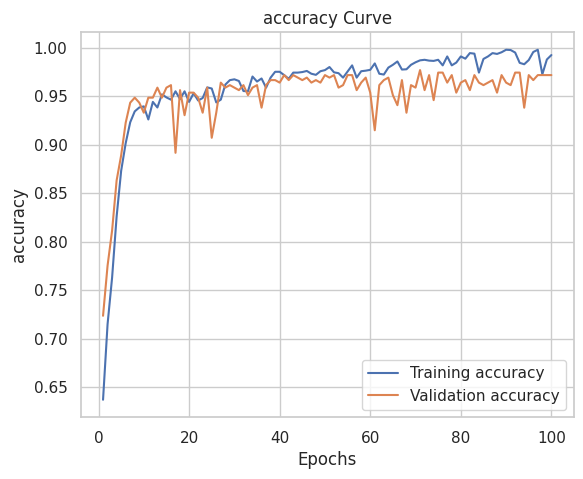

In [ ]:
loss = history_model_1.history['accuracy']
val_loss = history_model_1.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 5))

# Gráfico de loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training accuracy')
plt.plot(epochs, val_loss, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('accuracy Curve')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

model_1.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # No gradients needed
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_1(inputs)  # (batch_size, num_classes)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion Matrix and Classification Report
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)
TN, FP, FN, TP = cm.ravel()

TPR = TP / (TP + FN)  # Same as Recall
TNR = TN / (TN + FP)  # True Negative Rate
models_metrics['TPR']['model_1'] = TPR
models_metrics['TNR']['model_1'] = TNR

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Confusion Matrix:
[[398 112]
 [ 98 392]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       510
           1       0.78      0.80      0.79       490

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



In [ ]:
# Obtener el classification report en formato dict
report = classification_report(all_labels, all_preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Guardar métricas para cada clase
for label in df_report.index:
    if label in ['accuracy', 'macro avg', 'weighted avg']:
        continue  # Saltamos los promedios globales

    label_clean = str(int(float(label)))  # '0.0' → '0', 0 → '0', etc.
    key = f"model_1_{'negative' if label_clean == '0' else 'positive'}"

    for metric in ['precision', 'recall', 'f1-score']:
        models_metrics[metric][key] = df_report.loc[label, metric]

# Guardar predicciones
models_metrics['predictions']['model_1'] = all_preds.tolist()

In [ ]:
models_metrics

{'precision': {'nn_negative': 0.8183586153247764,
  'nn_positive': 0.8841359080909313,
  'svc_positive': 0.8586728754365541,
  'svc_negative': 0.8252328878088295,
  'rf_positive': 0.8397905759162304,
  'rf_negative': 0.8786451323463437,
  'model_1_negative': 0.8024193548387096,
  'model_1_positive': 0.7777777777777778},
 'recall': {'nn_negative': 0.8987612131567706,
  'nn_positive': 0.7947703801362338,
  'svc_positive': 0.8103713469567128,
  'svc_negative': 0.8703545493378898,
  'rf_positive': 0.8811250274664909,
  'rf_negative': 0.8366082870568133,
  'model_1_negative': 0.7803921568627451,
  'model_1_positive': 0.8},
 'f1': {'svc_positive': 0.8338231969251639,
  'svc_negative': 0.8471933471933472,
  'rf_positive': 0.8599613982414754,
  'rf_negative': 0.8571115973741794},
 'TPR': {'nn': 0.7947703801362338,
  'svc': 0.8103713469567128,
  'rf': 0.8811250274664909,
  'model_2': 0.991650186772138,
  'model_1': 0.8},
 'TNR': {'nn': 0.8987612131567706,
  'svc': 0.8703545493378898,
  'rf': 0.

## Test Screening

In [ ]:

# Set fixed parameters once
screening_instance.mirna_gap = 250
screening_instance.screen_size = 164

iou_values = []
precision_values = []
recall_values = []
accuracy_values = []
speed_values = []

threshold_values = [0.3, 0.5, 0.7]
prob_output_label = 'y' # 'y_ws_100_mean'

for threshold in threshold_values:
    for i in range(0, len(mirnas_for_screening), 100):
        # Update sequences for the current batch
        screening_instance.positive_sequences = mirnas_for_screening[i:i+5]
        screening_instance.negative_sequences = neg_sampled_sequences_for_screening[i:i+5]

        # Regenerate everything with new sequences
        screening_instance.generate_sequence_for_screening()
        screening_instance.get_results_with_word2vec_and_model_1(model=model_1, smooth_size=50, smooth_type="mean")

        # Calculate metrics
        y_predicted = screening_instance.df[prob_output_label]
        iou = screening_instance.calculate_iou(y_predicted, threshold=threshold)
        precision = screening_instance.calculate_precision(y_predicted, threshold=threshold)
        recall = screening_instance.calculate_recall(y_predicted, threshold=threshold)
        accuracy = screening_instance.calculate_accuracy(y_predicted, threshold=threshold)

        # Save evaluation results
        screening_instance.evaluate_screening(
            y_predicted, 
            model_name=f"model1_th_{threshold}_{i}",
            threshold=threshold,
            additional_metrics={
                'IOU': iou,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'Speed_nt_per_sec': screening_instance.nt_per_second
            })

        # Collect metrics
        iou_values.append(iou)
        precision_values.append(precision)
        recall_values.append(recall)
        accuracy_values.append(accuracy)
        speed_values.append(screening_instance.nt_per_second)

        #break # eliminar cuando se tenga tiempo para ejecutar el script

# Compute variance and mean
iou_variance = np.var(iou_values)
iou_mean = np.mean(iou_values)
precision_variance = np.var(precision_values)
precision_mean = np.mean(precision_values)
recall_variance = np.var(recall_values)
recall_mean = np.mean(recall_values)
accuracy_mean = np.mean(accuracy_values)


/tmp/ipykernel_1077478/3342887032.py:340: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch_tensor = torch.tensor(inputs_batch, dtype=torch.float32).permute(0, 3, 1, 2).to(device)


time executed: 356.1242344379425 seconds
time executed: 366.1680042743683 seconds
time executed: 386.8805458545685 seconds
time executed: 369.8891863822937 seconds
time executed: 378.76435256004333 seconds
time executed: 357.8717873096466 seconds
time executed: 364.42710995674133 seconds
time executed: 387.1045615673065 seconds
time executed: 372.25541520118713 seconds
time executed: 373.5288436412811 seconds
time executed: 356.895804643631 seconds
time executed: 365.4171447753906 seconds
time executed: 387.3497648239136 seconds
time executed: 370.39626455307007 seconds
time executed: 373.4713706970215 seconds


In [ ]:
print(f"Screening IoU: {iou_mean:.4f} ± {iou_variance**0.5:.4f}")
print(f"Screening precision: {precision_mean:.4f} ± {precision_variance**0.5:.4f}")
print(f"Screening recall: {recall_mean:.4f} ± {recall_variance**0.5:.4f}")

Screening IoU: 0.2357 ± 0.0761
Screening precision: 0.0444 ± 0.0204
Screening recall: 0.8133 ± 0.2247


In [ ]:
speed_variance = np.var(speed_values)
speed_mean = np.mean(speed_values)
print(f"Screening speed: {speed_mean:.4f}nt/s ± {speed_variance**0.5:.4f}")
speed_model_1 = speed_mean
iou_model_1 = iou_mean
precision_model_1 = precision_mean
recall_model_1 = recall_mean
accuracy_model_1 = accuracy_mean

Screening speed: 5.1064nt/s ± 0.0275


In [ ]:
screening_instance.metrics_df

,model_name,threshold,TPR,TNR,GMeans,IOU,Precision,Recall,Accuracy,Speed_nt_per_sec
0,nn_th_0.3_0,0.3,0.840000,0.839874,0.839937,0.307800,0.111702,0.840000,0.109375,2346.74
1,nn_th_0.3_100,0.3,0.690000,0.799504,0.742737,0.227242,0.110400,0.690000,0.105183,2277.67
2,nn_th_0.3_200,0.3,0.730000,0.881484,0.802174,0.285874,0.121464,0.730000,0.116242,2347.99
3,nn_th_0.3_300,0.3,0.750000,0.860961,0.803567,0.271107,0.115385,0.750000,0.111111,2347.89
4,nn_th_0.3_400,0.3,0.710000,0.914524,0.805799,0.277131,0.121160,0.710000,0.115447,2348.75
...,...,...,...,...,...,...,...,...,...,...
63,nn_var,NaN,0.008021,0.002346,0.001619,0.000996,0.000116,0.008021,0.000066,615.56
64,rf_avg,0.5,0.767333,0.672230,0.675895,0.231957,0.097830,0.725333,0.093211,2217.98
65,rf_var,NaN,0.052264,0.069945,0.009534,0.004052,0.000162,0.037470,0.000148,417.87
66,svm_avg,0.5,0.751333,0.801985,0.769064,0.238133,0.106493,0.748000,0.102397,2154.26


# Model 2

In [ ]:
max_seq_len = max(len(seq) for seq in positive_sequences)
max_seq_len = 164
X_train_model_2 = preprocess_dna_sequences(X_train, max_seq_len)
X_test_model_2 = preprocess_dna_sequences(X_test, max_seq_len)
X_train_model_2.shape


(73862, 164, 4)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Model_2(nn.Module):
    def __init__(self, input_length=164, num_filters=128, kernel_height=6, kernel_width=4,
                 lstm_units=100, dense_units=64, dropout_rate=0.5):
        super(Model_2, self).__init__()
        
        time_steps = input_length // kernel_height  # Calculate time steps
        self.num_filters = num_filters
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(kernel_height, kernel_width), padding='same')
        self.conv2 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(kernel_height, kernel_width), padding='same')
        self.conv3 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(kernel_height, kernel_width), padding='same')
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=num_filters * 4, hidden_size=lstm_units, batch_first=True, dropout=dropout_rate)
        
        # Fully connected layers
        self.fc1 = nn.Linear(lstm_units, dense_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(dense_units, 2)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for CNN (batch_size, 1, 164, 4)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = x.permute(0, 2, 1, 3).reshape(x.shape[0], -1, self.num_filters * 4)  # Reshape for LSTM (batch_size, time_steps, features)
        
        _, (h_n, _) = self.lstm(x)  # Use last hidden state from LSTM
        x = h_n[-1]
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Use log_softmax for numerical stability


/home/jopazo/miniconda3/envs/test/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Batch X shape: torch.Size([16, 164, 4])
Batch y shape: torch.Size([16])


Epoch 1/10, Train Loss: 0.3475, Val Loss: 0.2143
Epoch 2/10, Train Loss: 0.1037, Val Loss: 0.0551
Epoch 3/10, Train Loss: 0.0450, Val Loss: 0.0463
Epoch 4/10, Train Loss: 0.0308, Val Loss: 0.0383
Epoch 5/10, Train Loss: 0.0233, Val Loss: 0.0471
Epoch 6/10, Train Loss: 0.0195, Val Loss: 0.0356
Epoch 7/10, Train Loss: 0.0163, Val Loss: 0.0207
Epoch 8/10, Train Loss: 0.0149, Val Loss: 0.0230
Epoch 9/10, Train Loss: 0.0156, Val Loss: 0.0285
Epoch 10/10, Train Loss: 0.0156, Val Loss: 0.0353


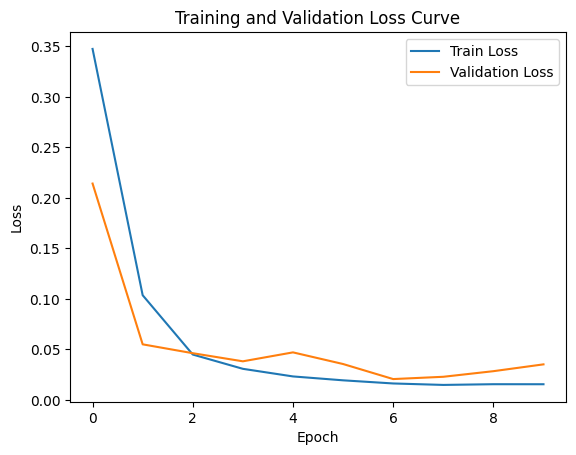

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = Model_2()
model_2.to(device)
# Definir el criterio de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert one-hot encoded sequences and labels to PyTorch tensors
X_train_tensor = torch.tensor(X_train_model_2, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

X_val_tensor = torch.tensor(X_test_model_2, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test_model_2, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Define batch size
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify shape of a batch
X_batch, y_batch = next(iter(train_loader))
print(f"Batch X shape: {X_batch.shape}")  # Expected: (batch_size, max_seq_len, 4)
print(f"Batch y shape: {y_batch.shape}")  # Expected: (batch_size,)


# Función para entrenar el modelo
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        val_loss = evaluate_model(model, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Función para evaluar el modelo
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
    
    return total_loss / len(loader)

# Entrenar el modelo
train_losses, val_losses = train_model(model_2, train_loader, val_loader, criterion, optimizer, epochs=10)

# Graficar la curva de pérdida
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.show()


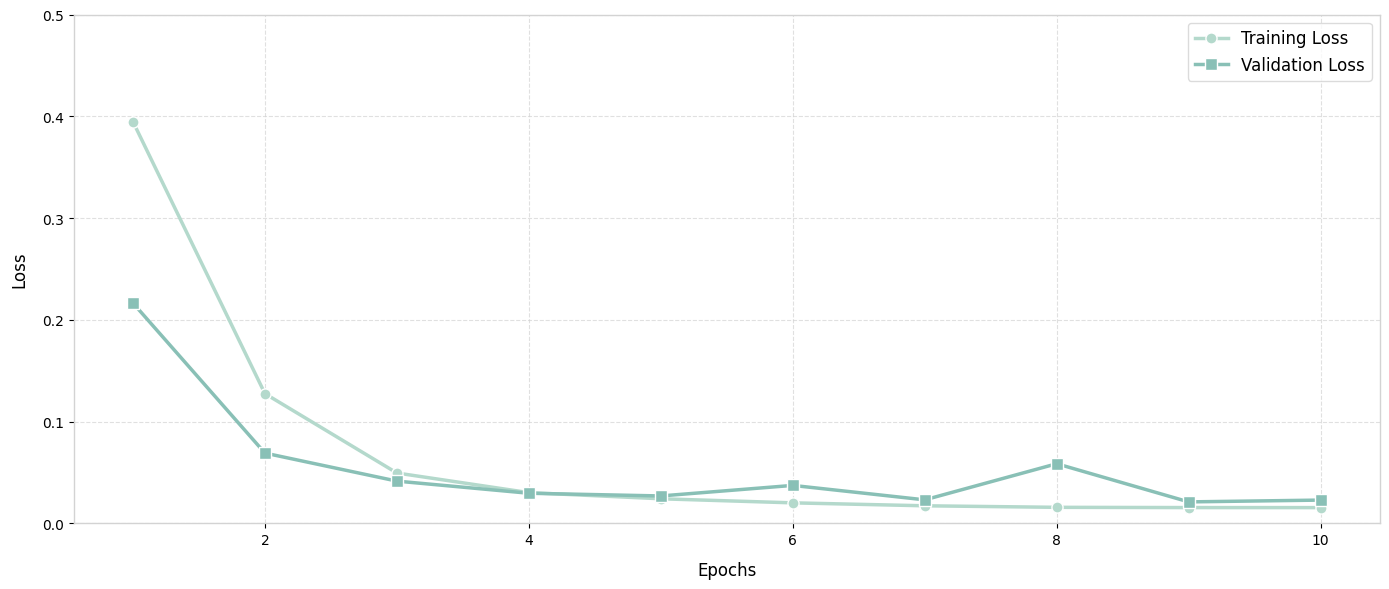

In [ ]:
plot_loss_curve(train_losses, val_losses, ymin=0, ymax=0.5)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Put model in evaluation mode
model_2.eval()

# Initialize lists for true & predicted labels
all_preds = []
all_labels = []

# Move model to device (GPU or CPU)
model_2.to(device)

with torch.no_grad():
    for batch in val_loader:  # Process in small batches
        X_batch, y_batch = batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Get predictions
        outputs = model_2(X_batch)
        _, y_pred = torch.max(outputs, 1)  # Get predicted class

        # Store results
        all_preds.extend(y_pred.cpu().numpy())  # Move to CPU before storing
        all_labels.extend(y_batch.cpu().numpy())

# Convert to NumPy arrays for evaluation
y_true = np.array(all_labels)
y_pred = np.array(all_preds)


## Confusion Matrix

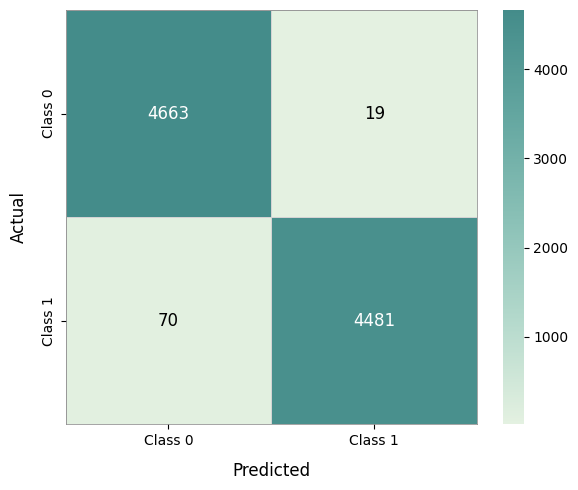

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()

TPR = TP / (TP + FN)  # Same as Recall
TNR = TN / (TN + FP)  # True Negative Rate
models_metrics['TPR']['model_2'] = TPR
models_metrics['TNR']['model_2'] = TNR

# Plotly Mint color palette (hex values)
mint_palette = [
        '#e4f1e1', 
        '#b4d9cc', 
        '#89c0b6', 
        '#63a6a0', 
        '#448c8a', 
        # '#287274', 
        # '#0d585f'
    ]

# Create custom colormap
mint_cmap = LinearSegmentedColormap.from_list("plotly_mint", mint_palette)

# Plot confusion matrix with mint palette
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap=mint_cmap,
    xticklabels=["Class 0", "Class 1"], 
    yticklabels=["Class 0", "Class 1"],
    linewidths=.5,
    linecolor='lightgray',
    annot_kws={"size": 12}  # Font size for annotations
)

# Set text color to white for dark cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Get cell color and calculate brightness
        rgba = heatmap.get_children()[0].get_facecolors()[i*cm.shape[1]+j]
        brightness = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
        # Use white text for dark cells, black for light cells
        heatmap.texts[i*cm.shape[1]+j].set_color('white' if brightness < 0.6 else 'black')

# Styling
plt.xlabel("Predicted", fontsize=12, labelpad=10)
plt.ylabel("Actual", fontsize=12, labelpad=10)
#plt.title("Confusion Matrix", fontsize=14, pad=15)

# Add border
for spine in heatmap.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('gray')
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.show()

In [ ]:
# Print classification report (accuracy, precision, recall, F1-score)
print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))


              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99      4682
     Class 1       1.00      0.98      0.99      4551

    accuracy                           0.99      9233
   macro avg       0.99      0.99      0.99      9233
weighted avg       0.99      0.99      0.99      9233



In [ ]:
# Obtener el classification report en formato dict
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Guardar métricas para cada clase
for label in df_report.index:
    if label in ['accuracy', 'macro avg', 'weighted avg']:
        continue  # Saltamos los promedios globales

    label_clean = str(int(float(label)))  # '0.0' → '0', 0 → '0', etc.
    key = f"model_2_{'negative' if label_clean == '0' else 'positive'}"

    for metric in ['precision', 'recall', 'f1-score']:
        models_metrics[metric][key] = df_report.loc[label, metric]

# Guardar predicciones
models_metrics['predictions']['model_2'] = y_pred.tolist()

In [ ]:
models_metrics

{'precision': {'nn_negative': 0.8183586153247764,
  'nn_positive': 0.8841359080909313,
  'svc_positive': 0.8586728754365541,
  'svc_negative': 0.8252328878088295,
  'rf_positive': 0.8397905759162304,
  'rf_negative': 0.8786451323463437,
  'model_1_negative': 0.8024193548387096,
  'model_1_positive': 0.7777777777777778,
  'model_2_negative': 0.9852102260722586,
  'model_2_positive': 0.9957777777777778},
 'recall': {'nn_negative': 0.8987612131567706,
  'nn_positive': 0.7947703801362338,
  'svc_positive': 0.8103713469567128,
  'svc_negative': 0.8703545493378898,
  'rf_positive': 0.8811250274664909,
  'rf_negative': 0.8366082870568133,
  'model_1_negative': 0.7803921568627451,
  'model_1_positive': 0.8,
  'model_2_negative': 0.9959419051687313,
  'model_2_positive': 0.98461876510657},
 'f1': {'svc_positive': 0.8338231969251639,
  'svc_negative': 0.8471933471933472,
  'rf_positive': 0.8599613982414754,
  'rf_negative': 0.8571115973741794},
 'TPR': {'nn': 0.7947703801362338,
  'svc': 0.81037

In [ ]:
models_metrics['f1-score']

{'nn_negative': 0.8667598666523282,
 'nn_positive': 0.8648412784989636,
 'model_1_negative': 0.8807157057654076,
 'model_1_positive': 0.8792756539235412,
 'model_2_negative': 0.9917052676936335,
 'model_2_positive': 0.9916149406512033}

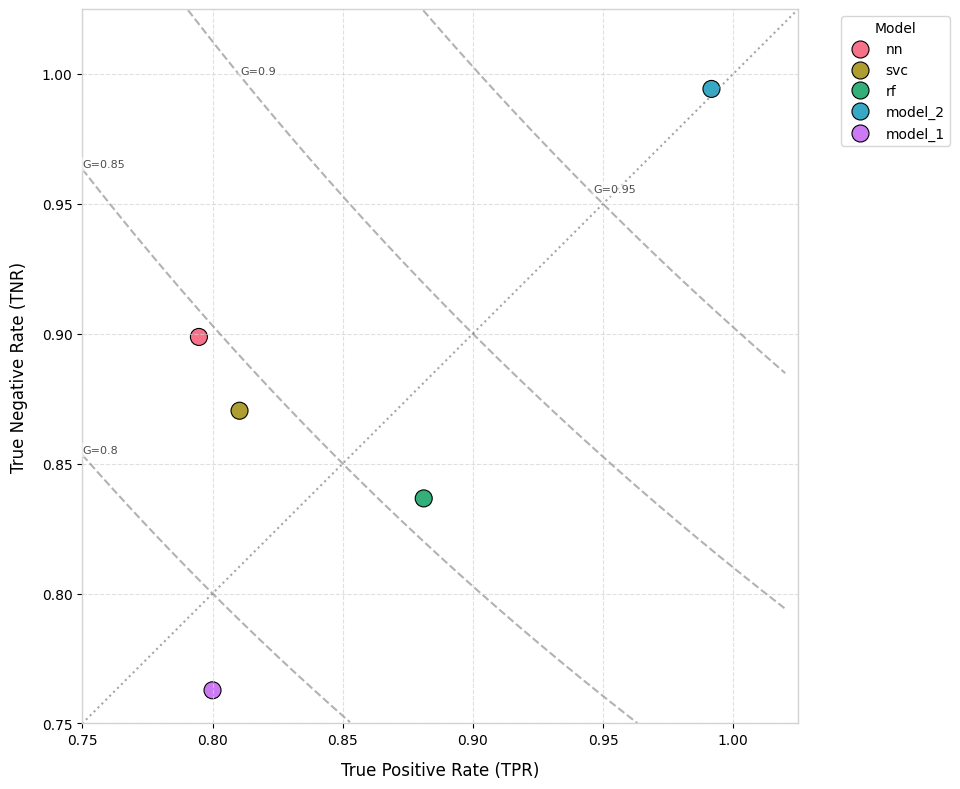

In [ ]:
def plot_tpr_tnr_gmean(metrics_dict, figsize=(10, 8), plot_only_averages=False):
    """
    Plot TPR vs TNR with G-Mean isolines using husl color palette.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Extract metrics and create DataFrame
    tpr_data = metrics_dict.get('TPR', {})
    tnr_data = metrics_dict.get('TNR', {})
    models = list(tpr_data.keys())
    
    data = {
        'model_name': models,
        'TPR': [tpr_data[m] for m in models],
        'TNR': [tnr_data[m] for m in models],
        'GMeans': [np.sqrt(tpr_data[m] * tnr_data[m]) for m in models]
    }
    metrics_df = pd.DataFrame(data)

    # Filter if needed
    plot_df = (metrics_df[metrics_df['model_name'].str.contains('_avg')] 
              if plot_only_averages else metrics_df.copy())

    if len(plot_df) == 0:
        raise ValueError("No models found matching filter criteria")

    # Set up plot
    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    # Apply husl color palette
    palette = sns.color_palette("husl", len(plot_df['model_name'].unique()))
    
    # Set grid style
    plt.grid(True, linestyle='--', color='lightgray', alpha=0.7)
    
    # Plot reference line
    plt.plot([0, 1.05], [0, 1.05], 'gray', linestyle=':', alpha=0.7, linewidth=1.5)

    # Plot G-Mean isolines
    gmean_levels = [0.8, 0.85, 0.9, 0.95]
    tpr_vals = np.linspace(0.75, 1.02, 500)

    for gmean in gmean_levels:
        tnr_vals = (gmean ** 2) / tpr_vals
        valid_idx = (tnr_vals >= 0.75) & (tnr_vals <= 1.025)
        plt.plot(tpr_vals[valid_idx], tnr_vals[valid_idx], linestyle='--', color='gray', alpha=0.6)
        # Label the isoline at the middle point
        mid_idx = np.argmax(valid_idx) // 2
        if valid_idx.any():
            plt.text(
                tpr_vals[valid_idx][mid_idx],
                tnr_vals[valid_idx][mid_idx],
                f"G={gmean}",
                fontsize=8,
                color='black',
                alpha=0.7,
                ha='left',
                va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.5, lw=0)
            )

    # Create scatter plot
    sns.scatterplot(
        data=plot_df,
        x='TPR',
        y='TNR',
        hue='model_name',
        palette=palette,
        s=150,
        edgecolor='black',
        linewidth=0.8,
        ax=ax
    )

    # Final styling
    #plt.title('TPR vs TNR with G-Mean Isolines', fontsize=14, pad=15)
    plt.xlabel('True Positive Rate (TPR)', fontsize=12, labelpad=10)
    plt.ylabel('True Negative Rate (TNR)', fontsize=12, labelpad=10)
    plt.xlim(0.75, 1.025)
    plt.ylim(0.75, 1.025)
    
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('lightgray')
        spine.set_linewidth(1)

    plt.tight_layout()
    plt.show()


plot_tpr_tnr_gmean(models_metrics, figsize=(9.72, 8), plot_only_averages=False)

In [ ]:
X_test_model_2
pos_seq_for_debug = []
neg_seq_for_debug = []
cont = 0
for idx in range(X_test.__len__()):
    if cont == 10:
        break
    if y_test[idx] == 1:
        pos_seq_for_debug.append(X_test[idx])
        cont += 1
    else:
        neg_seq_for_debug.append(X_test[idx])

neg_seq_for_debug.append(X_test[idx+1])


time executed: 0.5288124084472656 seconds


/tmp/ipykernel_2901623/1618260100.py:688: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


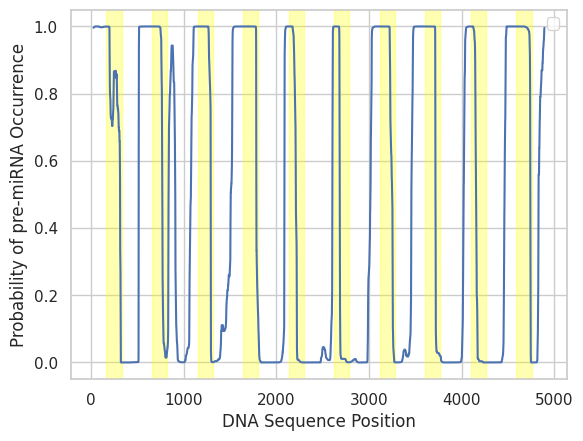

In [ ]:
first_screening_instance = Screening(positive_sequences=mirnas_for_screening[:100])
first_screening_instance.mirna_gap = 250
first_screening_instance.screen_size = 164
first_screening_instance.generate_sequence_for_screening(debug=True, pos_seq_for_debug=pos_seq_for_debug,neg_seq_for_debug=neg_seq_for_debug, num_of_negatives=2)
first_screening_instance.get_results_with_model_2(model=model_2, smooth_size=50, smooth_type="median")
first_screening_instance.show_lineplot(column="y_ws_50_median")

/tmp/ipykernel_2901623/1618260100.py:688: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


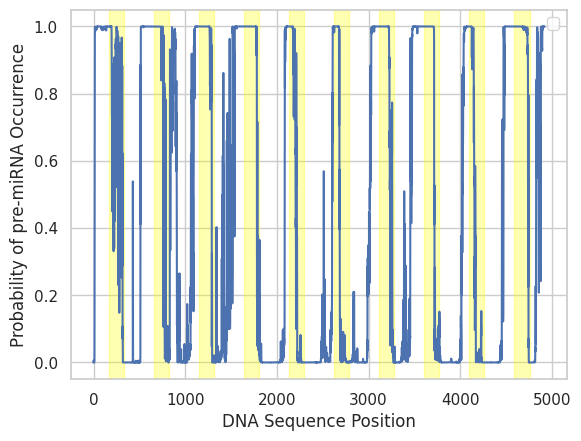

In [ ]:
first_screening_instance.show_lineplot(column="y")

hacer otra prueba con 1 positivo y 2 negativos concatenados, luego 1 positivo y 3 negativos, esto para entender si el efecto de proximidad es el que afecta las metricas mostradas en la matriz de confusion

In [ ]:
first_screening_instance.df.describe()

,x,y,y_ws_50_median
count,2184.000000,2184.000000,2135.000000
mean,1091.500000,0.439872,0.434284
std,630.610815,0.116686,0.094005
min,0.000000,0.245917,0.290340
25%,545.750000,0.358120,0.369197
50%,1091.500000,0.404329,0.404306
75%,1637.250000,0.493510,0.464767
max,2183.000000,0.886374,0.699553


time executed: 0.507838249206543 seconds


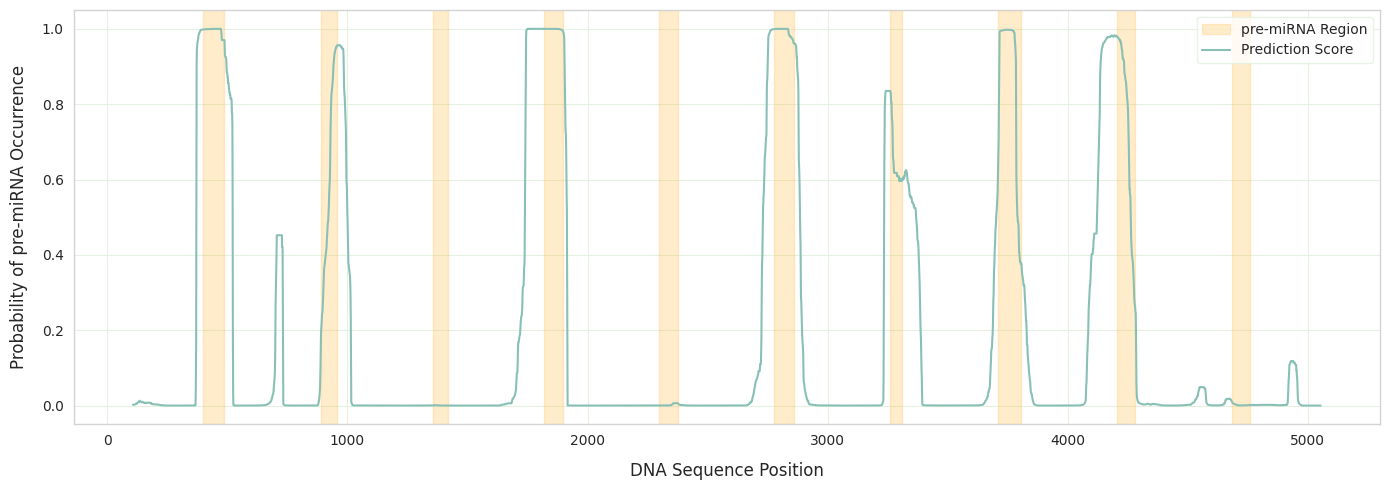

In [ ]:
first_screening_instance = Screening(positive_sequences=mirnas_for_screening[:10], negative_sequences=neg_sampled_sequences_for_screening[:100])
first_screening_instance.mirna_gap = 400
first_screening_instance.screen_size = 164
first_screening_instance.generate_sequence_for_screening()
first_screening_instance.get_results_with_model_2(model=model_2, smooth_size=50, smooth_type="median")
first_screening_instance.show_lineplot(column="y_ws_50_median")

In [ ]:

# Set fixed parameters once
screening_instance.mirna_gap = 250
screening_instance.screen_size = 164

iou_values = []
precision_values = []
recall_values = []
accuracy_values = []
speed_values = []

threshold_values = [0.3, 0.5, 0.7]
prob_output_label = 'y' # 'y_ws_100_mean'

for threshold in threshold_values:
    for i in range(0, len(mirnas_for_screening), 100):
        # Update sequences for the current batch
        screening_instance.positive_sequences = mirnas_for_screening[i:i+100]
        screening_instance.negative_sequences = neg_sampled_sequences_for_screening[i:i+100]

        # Regenerate everything with new sequences
        screening_instance.generate_sequence_for_screening()
        screening_instance.get_results_with_model_2(model=model_2, smooth_size=50, smooth_type="mean", batch_size=32)

        # Calculate metrics
        y_predicted = screening_instance.df[prob_output_label]
        iou = screening_instance.calculate_iou(y_predicted, threshold=threshold)
        precision = screening_instance.calculate_precision(y_predicted, threshold=threshold)
        recall = screening_instance.calculate_recall(y_predicted, threshold=threshold)
        accuracy = screening_instance.calculate_accuracy(y_predicted, threshold=threshold)

        # Save evaluation results
        screening_instance.evaluate_screening(
            y_predicted, 
            model_name=f"model2_th_{threshold}_{i}",
            threshold=threshold,
            additional_metrics={
                'IOU': iou,
                'Precision': precision,
                'Recall': recall,
                'Accuracy': accuracy,
                'Speed_nt_per_sec': screening_instance.nt_per_second
            })

        # Collect metrics
        iou_values.append(iou)
        precision_values.append(precision)
        recall_values.append(recall)
        accuracy_values.append(accuracy)
        speed_values.append(screening_instance.nt_per_second)

# Compute variance and mean
iou_variance = np.var(iou_values)
iou_mean = np.mean(iou_values)
precision_variance = np.var(precision_values)
precision_mean = np.mean(precision_values)
recall_variance = np.var(recall_values)
recall_mean = np.mean(recall_values)
accuracy_mean = np.mean(accuracy_values)


time executed: 2.6514365673065186 seconds
time executed: 2.630246639251709 seconds
time executed: 2.622699499130249 seconds
time executed: 2.6236073970794678 seconds
time executed: 2.6500236988067627 seconds
time executed: 2.6476218700408936 seconds
time executed: 2.6287896633148193 seconds
time executed: 2.622821807861328 seconds
time executed: 2.624472141265869 seconds
time executed: 2.6468114852905273 seconds
time executed: 2.638814926147461 seconds
time executed: 2.613680601119995 seconds
time executed: 2.618340253829956 seconds
time executed: 2.6108038425445557 seconds
time executed: 2.637159585952759 seconds


In [ ]:
print(f"Screening IoU: {iou_mean:.4f} ± {iou_variance**0.5:.4f}")
print(f"Screening precision: {precision_mean:.4f} ± {precision_variance**0.5:.4f}")
print(f"Screening recall: {recall_mean:.4f} ± {recall_variance**0.5:.4f}")

Screening IoU: 0.3273 ± 0.0196
Screening precision: 0.1598 ± 0.0094
Screening recall: 0.7207 ± 0.0474


In [ ]:
speed_variance = np.var(speed_values)
speed_mean = np.mean(speed_values)
print(f"Screening speed: {speed_mean:.4f}nt/s ± {speed_variance**0.5:.4f}")
speed_model_2 = speed_mean
iou_model_2 = iou_mean
precision_model_2 = precision_mean
recall_model_2 = recall_mean
accuracy_model_2 = accuracy_mean

Screening speed: 12740.2372nt/s ± 32.4462


In [ ]:
screening_instance.metrics_df

,model_name,threshold,TPR,TNR,GMeans,IOU,Precision,Recall,Accuracy,Speed_nt_per_sec
0,nn_th_0.3_0,0.3,0.840000,0.839874,0.839937,0.307800,0.111702,0.840000,0.109375,2346.74
1,nn_th_0.3_100,0.3,0.690000,0.799504,0.742737,0.227242,0.110400,0.690000,0.105183,2277.67
2,nn_th_0.3_200,0.3,0.730000,0.881484,0.802174,0.285874,0.121464,0.730000,0.116242,2347.99
3,nn_th_0.3_300,0.3,0.750000,0.860961,0.803567,0.271107,0.115385,0.750000,0.111111,2347.89
4,nn_th_0.3_400,0.3,0.710000,0.914524,0.805799,0.277131,0.121160,0.710000,0.115447,2348.75
...,...,...,...,...,...,...,...,...,...,...
80,nn_var,NaN,0.008021,0.002346,0.001619,0.000996,0.000116,0.008021,0.000066,615.56
81,rf_avg,0.5,0.767333,0.672230,0.675895,0.231957,0.097830,0.725333,0.093211,2217.98
82,rf_var,NaN,0.052264,0.069945,0.009534,0.004052,0.000162,0.037470,0.000148,417.87
83,svm_avg,0.5,0.751333,0.801985,0.769064,0.238133,0.106493,0.748000,0.102397,2154.26


In [ ]:
print(screening_instance.metrics_df.sort_values(['model_name', 'threshold'])[18:35])

           model_name  threshold       TPR       TNR    GMeans       IOU  \
60    model2_th_0.3_0        0.3  0.800000  0.946437  0.870143  0.354424   
61  model2_th_0.3_100        0.3  0.740000  0.976658  0.850133  0.352960   
62  model2_th_0.3_200        0.3  0.750000  0.949256  0.843766  0.304481   
63  model2_th_0.3_300        0.3  0.750000  0.939220  0.839294  0.313893   
64  model2_th_0.3_400        0.3  0.770000  0.943843  0.852502  0.319459   
65    model2_th_0.5_0        0.5  0.720000  0.983536  0.841514  0.345090   
66  model2_th_0.5_100        0.5  0.720000  0.954105  0.828828  0.336258   
67  model2_th_0.5_200        0.5  0.710000  0.942490  0.818027  0.311422   
68  model2_th_0.5_300        0.5  0.650000  0.963351  0.791314  0.337192   
69  model2_th_0.5_400        0.5  0.770000  0.962111  0.860712  0.322165   
70    model2_th_0.7_0        0.7  0.770000  0.944294  0.852705  0.335836   
71  model2_th_0.7_100        0.7  0.680000  0.966171  0.810553  0.327943   
72  model2_t

In [ ]:
def update_aggregated_metrics(metrics_df):
    """Calculate mean metrics grouped by model type and threshold"""
    # Make a copy to avoid modifying the original
    df = metrics_df.copy()
    
    # First remove any existing aggregated rows
    df = df[~df['model_name'].str.contains('_avg|_var', na=False)]
    
    # Extract model type and threshold from model_name
    df['model_type'] = df['model_name'].str.extract(r'^([a-zA-Z]+[0-9]*)')[0]
    df['threshold'] = df['model_name'].str.extract(r'th_(\d\.\d)')[0].astype(float)
    
    # Identify numeric columns for aggregation (exclude model_name and threshold)
    numeric_cols = [col for col in df.select_dtypes(include=['number']).columns 
                   if col not in ['model_name']]
    
    # Calculate mean for each model_type and threshold group
    agg_results = []
    for (model, threshold), group_df in df.groupby(['model_type', 'threshold']):
        if len(group_df) > 1:  # Only aggregate if we have multiple runs
            mean_row = {
                'model_name': f"{model}_th_{threshold:.1f}_avg",
                'threshold': threshold
            }
            # Calculate mean for numeric columns
            mean_row.update(group_df[numeric_cols].mean().to_dict())
            agg_results.append(mean_row)
    
    # Combine with original data
    agg_df = pd.DataFrame(agg_results)
    return agg_df
    # self.metrics_df = pd.concat([df.drop(columns=['model_type']), agg_df], ignore_index=True)
    
    # # Clean up speed values
    # if 'Speed_nt_per_sec' in self.metrics_df.columns:
    #     self.metrics_df['Speed_nt_per_sec'] = self.metrics_df['Speed_nt_per_sec'].round(2)
    
    # # Sort by model name and threshold
    # self.metrics_df = self.metrics_df.sort_values(['model_name', 'threshold'])

metrics_df_agg = update_aggregated_metrics(screening_instance.metrics_df)
print(metrics_df_agg.sort_values(['model_name', 'threshold']))

           model_name  threshold    TPR       TNR    GMeans       IOU  \
0   model1_th_0.3_avg        0.3  0.800  0.785075  0.777478  0.249848   
1   model1_th_0.5_avg        0.5  0.760  0.718740  0.723903  0.199594   
2   model1_th_0.7_avg        0.7  0.880  0.705141  0.776726  0.257616   
3   model2_th_0.3_avg        0.3  0.762  0.951083  0.851168  0.329043   
4   model2_th_0.5_avg        0.5  0.714  0.961119  0.828079  0.330426   
5   model2_th_0.7_avg        0.7  0.686  0.968426  0.814487  0.322304   
6       nn_th_0.3_avg        0.3  0.744  0.859269  0.798843  0.273831   
7       nn_th_0.5_avg        0.5  0.656  0.928733  0.780062  0.245837   
8       nn_th_0.7_avg        0.7  0.558  0.950677  0.728119  0.221861   
9       rf_th_0.3_avg        0.3  0.978  0.345309  0.578270  0.274798   
10      rf_th_0.5_avg        0.5  0.856  0.715968  0.782289  0.274020   
11      rf_th_0.7_avg        0.7  0.468  0.955413  0.667127  0.147053   
12     svm_th_0.3_avg        0.3  0.868  0.684596  

/tmp/ipykernel_1077478/762264996.py:55: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


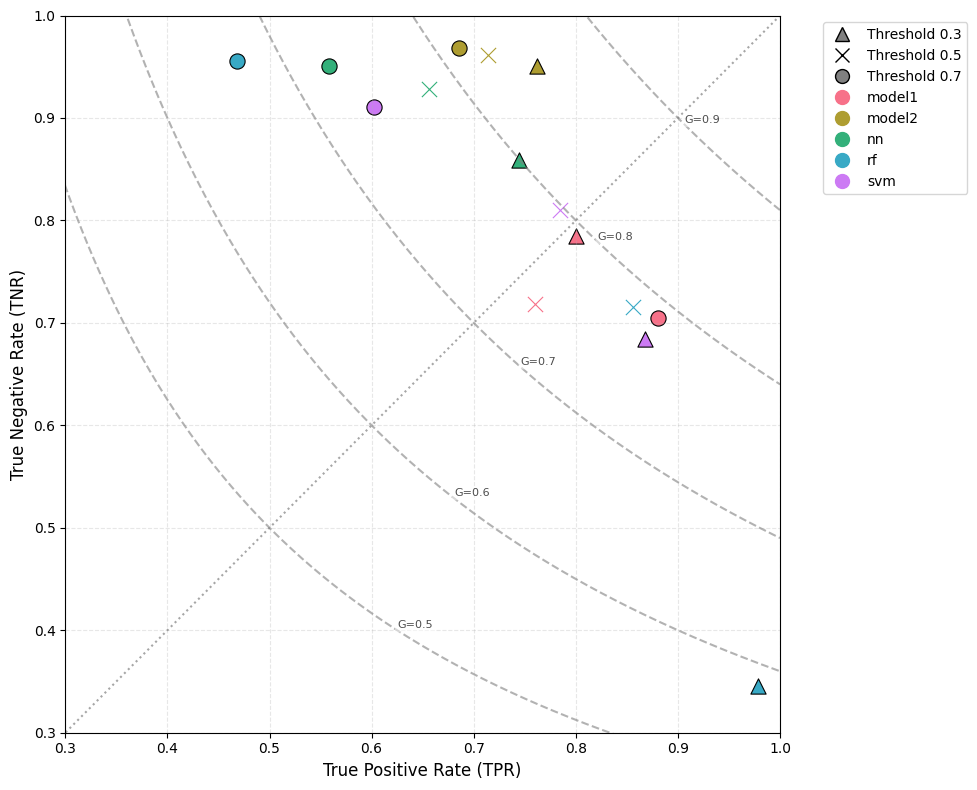

In [ ]:
def plot_tnr_tpr_gmeans(df):
    """Create scatterplot of TNR vs TPR with G-Mean isolines and marker styles per threshold"""
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(9.9, 8))
    
    # Threshold to marker mapping
    marker_map = {
        0.3: '^',
        0.5: 'x',
        0.7: 'o'
    }

    # Extract base model names and assign colors
    models = df['model_name'].str.extract(r'^([a-zA-Z]+[0-9]*)')[0].unique()
    palette = sns.color_palette("husl", len(models))
    color_map = {model: palette[i] for i, model in enumerate(models)}

    # Plot f(x) = x line
    plt.plot([0, 1], [0, 1], 
             color='gray', linestyle=':', alpha=0.7, linewidth=1.5)

    # Plot G-Mean isolines
    gmean_levels = [0.5, 0.6, 0.7, 0.8, 0.9]
    tpr_vals = np.linspace(0.01, 1.0, 500)

    for gmean in gmean_levels:
        tnr_vals = (gmean ** 2) / tpr_vals
        valid_idx = (tnr_vals >= 0) & (tnr_vals <= 1)
        # Subset of valid points
        valid_tpr = tpr_vals[valid_idx]
        valid_tnr = tnr_vals[valid_idx]
        plt.plot(tpr_vals[valid_idx], tnr_vals[valid_idx],
                 linestyle='--', color='gray', alpha=0.6)
        mid_idx = len(valid_tpr) // 2
        if valid_idx.any():
            plt.text(
                tpr_vals[valid_idx][mid_idx],
                tnr_vals[valid_idx][mid_idx],
                f"G={gmean}",
                fontsize=8,
                color='black',
                alpha=0.7,
                ha='left',
                va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.5, lw=0)
            )

    # Plot data points
    for _, row in df.iterrows():
        model = row['model_name'].split('_')[0]
        threshold = row['threshold']
        plt.scatter(
            x=row['TPR'],
            y=row['TNR'],
            marker=marker_map.get(threshold, 'o'),
            color=color_map[model],
            s=120,
            edgecolor='black',
            linewidth=0.8,
            label=f"{model} (th={threshold})"
        )
        # Optional: remove annotation if plot is too busy
        # plt.annotate(
        #     f"{model}\nGMeans={row['GMeans']:.3f}",
        #     (row['TPR'], row['TNR']),
        #     textcoords="offset points",
        #     xytext=(10, 5),
        #     ha='left',
        #     fontsize=9,
        #     bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7, lw=0.5)
        # )

    # Labels and limits
    #plt.title('TNR vs TPR by Model and Threshold with G-Mean Isolines', fontsize=14)
    plt.xlabel('True Positive Rate (TPR)', fontsize=12)
    plt.ylabel('True Negative Rate (TNR)', fontsize=12)
    plt.xlim(0.3, 1)
    plt.ylim(0.3, 1)
    plt.grid(True, linestyle='--', alpha=0.3)

    # Custom legend
    handles = []
    for threshold, marker in marker_map.items():
        handles.append(plt.Line2D([0], [0], 
                                  marker=marker, color='black',
                                  markerfacecolor='gray', markersize=10,
                                  label=f'Threshold {threshold}',
                                  linestyle='None'))
    for model, color in color_map.items():
        handles.append(plt.Line2D([0], [0],
                                  marker='o', color=color,
                                  markerfacecolor=color, markersize=10,
                                  label=model,
                                  linestyle='None'))
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_tnr_tpr_gmeans(metrics_df_agg)

In [ ]:
metrics_df_agg

,model_name,threshold,TPR,TNR,GMeans,IOU,Precision,Recall,Accuracy,Speed_nt_per_sec
0,model1_th_0.3_avg,0.3,0.800,0.785075,0.777478,0.249848,0.049946,0.800,0.047806,5.100
1,model1_th_0.5_avg,0.5,0.760,0.718740,0.723903,0.199594,0.046272,0.760,0.044109,5.106
2,model1_th_0.7_avg,0.7,0.880,0.705141,0.776726,0.257616,0.037002,0.880,0.036751,5.114
3,model2_th_0.3_avg,0.3,0.762,0.951083,0.851168,0.329043,0.158865,0.762,0.151253,12718.708
4,model2_th_0.5_avg,0.5,0.714,0.961119,0.828079,0.330426,0.161996,0.714,0.151810,12725.898
5,model2_th_0.7_avg,0.7,0.686,0.968426,0.814487,0.322304,0.158674,0.686,0.147748,12776.104
6,nn_th_0.3_avg,0.3,0.744,0.859269,0.798843,0.273831,0.116022,0.744,0.111472,2333.808
7,nn_th_0.5_avg,0.5,0.656,0.928733,0.780062,0.245837,0.117213,0.656,0.110303,2345.454
8,nn_th_0.7_avg,0.7,0.558,0.950677,0.728119,0.221861,0.125549,0.558,0.113957,2343.036
9,rf_th_0.3_avg,0.3,0.978,0.345309,0.578270,0.274798,0.107576,0.856,0.105590,2226.604


In [ ]:
metrics_df_agg.to_csv('metrics_df_agg.csv', index=False)  

In [ ]:
metrics_df_agg

,model_name,threshold,TPR,TNR,GMeans,IOU,Precision,Recall,Accuracy,Speed_nt_per_sec
0,model1_th_0.3_avg,0.3,0.880,0.553234,0.672856,0.174486,0.033291,0.880,0.032985,5.152
1,model1_th_0.5_avg,0.5,0.800,0.620564,0.694857,0.162316,0.026772,0.800,0.026418,5.148
2,model1_th_0.7_avg,0.7,0.840,0.670647,0.741758,0.116011,0.036304,0.840,0.035948,5.142
3,model2_th_0.3_avg,0.3,0.844,0.897880,0.870284,0.338575,0.149779,0.844,0.145613,12913.426
4,model2_th_0.5_avg,0.5,0.804,0.917411,0.858664,0.338712,0.152978,0.804,0.147452,12973.270
5,model2_th_0.7_avg,0.7,0.794,0.917163,0.852813,0.338545,0.158396,0.794,0.151946,12982.704
6,nn_th_0.3_avg,0.3,0.864,0.743978,0.801386,0.282315,0.112873,0.858,0.110820,2324.150
7,nn_th_0.5_avg,0.5,0.716,0.875981,0.791678,0.252110,0.114781,0.714,0.109680,2338.366
8,nn_th_0.7_avg,0.7,0.642,0.936198,0.775135,0.226532,0.127445,0.642,0.118944,2351.188
9,rf_th_0.3_avg,0.3,0.900,0.245354,0.468368,0.250428,0.993939,0.318,0.317366,2208.836


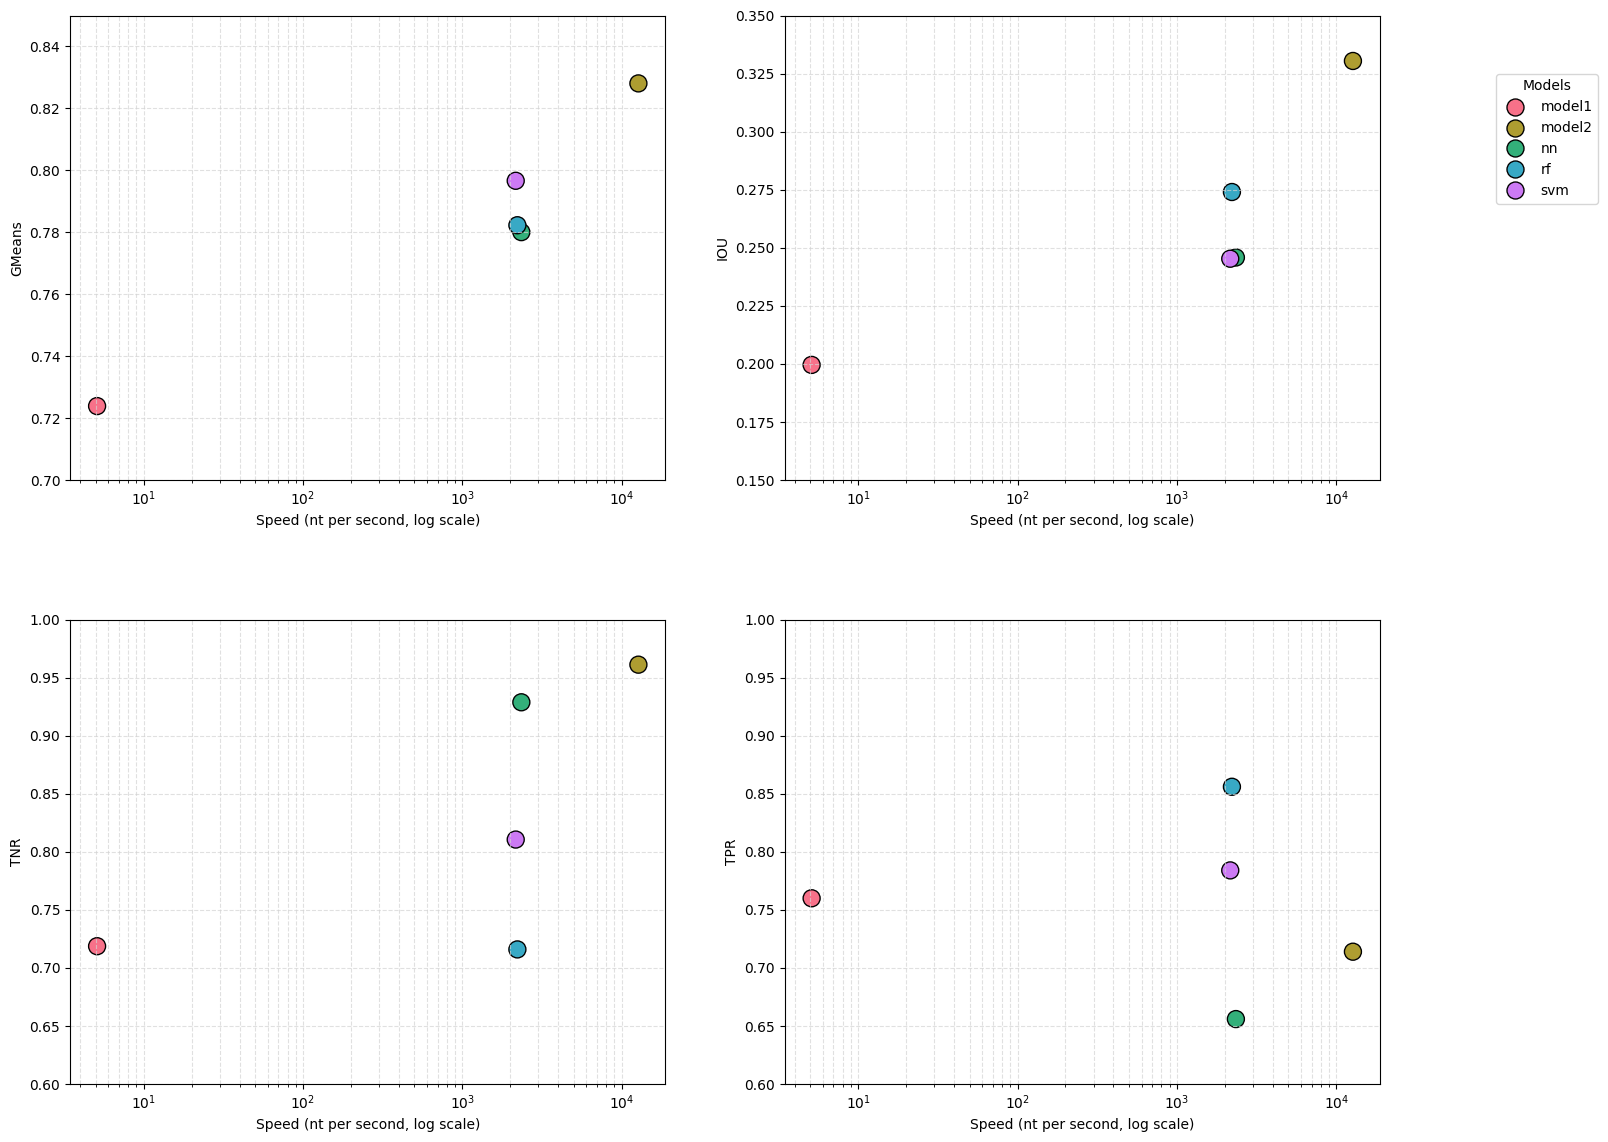

In [ ]:
def plot_metrics_vs_speed(metrics_df, threshold=None, figsize=(14, 12)):
    """
    Plots scatter plots of GMeans, IOU, TNR, TPR against Speed (log scale)
    
    Parameters:
    -----------
    metrics_df : pd.DataFrame
        DataFrame containing metrics data
    threshold : float, optional
        Specific threshold to filter by (e.g., 0.3, 0.5, 0.7)
    figsize : tuple, optional
        Size of the figure (width, height)
    """
    try:
        # Create a clean copy of the dataframe
        df = metrics_df.copy()
        
        # Filter for average rows
        avg_df = df[df['model_name'].str.endswith('_avg', na=False)]
        
        # Additional filtering by threshold if specified
        if threshold is not None:
            avg_df = avg_df[np.isclose(avg_df['threshold'], threshold)]
            title_suffix = f" (Threshold = {threshold})"
        else:
            title_suffix = ""
        
        if avg_df.empty:
            print("No data found matching the criteria")
            return
            
        # Verify required columns exist
        required_cols = ['Speed_nt_per_sec', 'GMeans', 'IOU', 'TNR', 'TPR']
        missing_cols = [col for col in required_cols if col not in avg_df.columns]
        if missing_cols:
            print(f"Missing required columns: {missing_cols}")
            return

        # Prepare data - create model names without '_avg' suffix
        plot_df = avg_df.copy()
        plot_df['Model'] = plot_df['model_name'].str.replace(r'_th_\d\.\d.*|_avg', '', regex=True)
        
        # Create figure
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        #fig.suptitle(f"Performance Metrics vs. Speed{title_suffix}", fontsize=16)
        
        # Define metrics and their positions
        metrics = [
            ('GMeans', 0, 0),
            ('IOU', 0, 1),
            ('TNR', 1, 0),
            ('TPR', 1, 1)
        ]

        # Create consistent color palette
        palette = sns.color_palette("husl", len(plot_df['Model'].unique()))
        
        for metric_name, row, col in metrics:
            ax = axes[row, col]
            
            # Create scatter plot
            sns.scatterplot(
                data=plot_df,
                x='Speed_nt_per_sec',
                y=metric_name,
                hue='Model',
                palette=palette,
                s=150,
                edgecolor='black',
                ax=ax
            )
            
            # Set log scale with improved ticks
            ax.set_xscale('log')
            # ax.set_yscale('log')
            ax.xaxis.set_major_locator(plt.LogLocator(numticks=5))
            # ax.yaxis.set_major_locator(plt.LogLocator(numticks=5))
            ax.xaxis.set_minor_locator(plt.LogLocator(subs='all', numticks=10))
            # ax.yaxis.set_minor_locator(plt.LogLocator(subs='all', numticks=10))
            
            # Custom grid styling (light gray dashed lines)
            ax.grid(True, which='both', linestyle='--', color='lightgray', alpha=0.7)
            
            # Add annotations
            # for _, row in plot_df.iterrows():
            #     ax.annotate(
            #         f"{row['Model']}\n{row[metric_name]:.3f}",
            #         (row['Speed_nt_per_sec'], row[metric_name]),
            #         textcoords="offset points",
            #         xytext=(8, 8),
            #         ha='center',
            #         fontsize=9,
            #         bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
            #     )
            
            # texts = []
            # for _, row in plot_df.iterrows():
            #     texts.append(
            #         ax.text(
            #             row['Speed_nt_per_sec'], 
            #             row[metric_name], 
            #             f"{row['Model']}\n{row[metric_name]:.3f}",
            #             fontsize=9,
            #             bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
            #         )
            #     )

            # adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

            #ax.set_title(f"{metric_name} vs Speed", fontsize=12)
            ax.set_xlabel("Speed (nt per second, log scale)", fontsize=10)
            ax.set_ylabel(metric_name, fontsize=10)
            
            # Set consistent y-axis limits
            if metric_name in ['TPR']:
                ax.set_ylim(0.6, 1)
            elif metric_name == 'TNR':
                ax.set_ylim(0.6, 1)
            elif metric_name == 'GMeans':
                ax.set_ylim(0.7, 0.85)
            elif metric_name == 'IOU':
                ax.set_ylim(0.15, 0.35)
        
        # Adjust legend
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(
            handles=handles,
            labels=labels,
            title='Models',
            loc='upper right',
            bbox_to_anchor=(1.15, 0.9),
            fontsize=10
        )
        
        # Remove individual plot legends
        for ax in axes.flat:
            if ax.get_legend() is not None:
                ax.get_legend().remove()
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        fig.subplots_adjust(wspace=0.2, hspace=0.3)
        plt.show()
        
    except Exception as e:
        print(f"Error generating plots: {str(e)}")

plot_metrics_vs_speed(metrics_df_agg, threshold=0.5, figsize=(14, 12))

In [ ]:
metrics_df_agg

,model_name,threshold,TPR,TNR,GMeans,IOU,Precision,Recall,Accuracy,Speed_nt_per_sec
0,model1_th_0.3_avg,0.3,0.800,0.785075,0.777478,0.249848,0.049946,0.800,0.047806,5.100
1,model1_th_0.5_avg,0.5,0.760,0.718740,0.723903,0.199594,0.046272,0.760,0.044109,5.106
2,model1_th_0.7_avg,0.7,0.880,0.705141,0.776726,0.257616,0.037002,0.880,0.036751,5.114
3,model2_th_0.3_avg,0.3,0.762,0.951083,0.851168,0.329043,0.158865,0.762,0.151253,12718.708
4,model2_th_0.5_avg,0.5,0.714,0.961119,0.828079,0.330426,0.161996,0.714,0.151810,12725.898
5,model2_th_0.7_avg,0.7,0.686,0.968426,0.814487,0.322304,0.158674,0.686,0.147748,12776.104
6,nn_th_0.3_avg,0.3,0.744,0.859269,0.798843,0.273831,0.116022,0.744,0.111472,2333.808
7,nn_th_0.5_avg,0.5,0.656,0.928733,0.780062,0.245837,0.117213,0.656,0.110303,2345.454
8,nn_th_0.7_avg,0.7,0.558,0.950677,0.728119,0.221861,0.125549,0.558,0.113957,2343.036
9,rf_th_0.3_avg,0.3,0.978,0.345309,0.578270,0.274798,0.107576,0.856,0.105590,2226.604


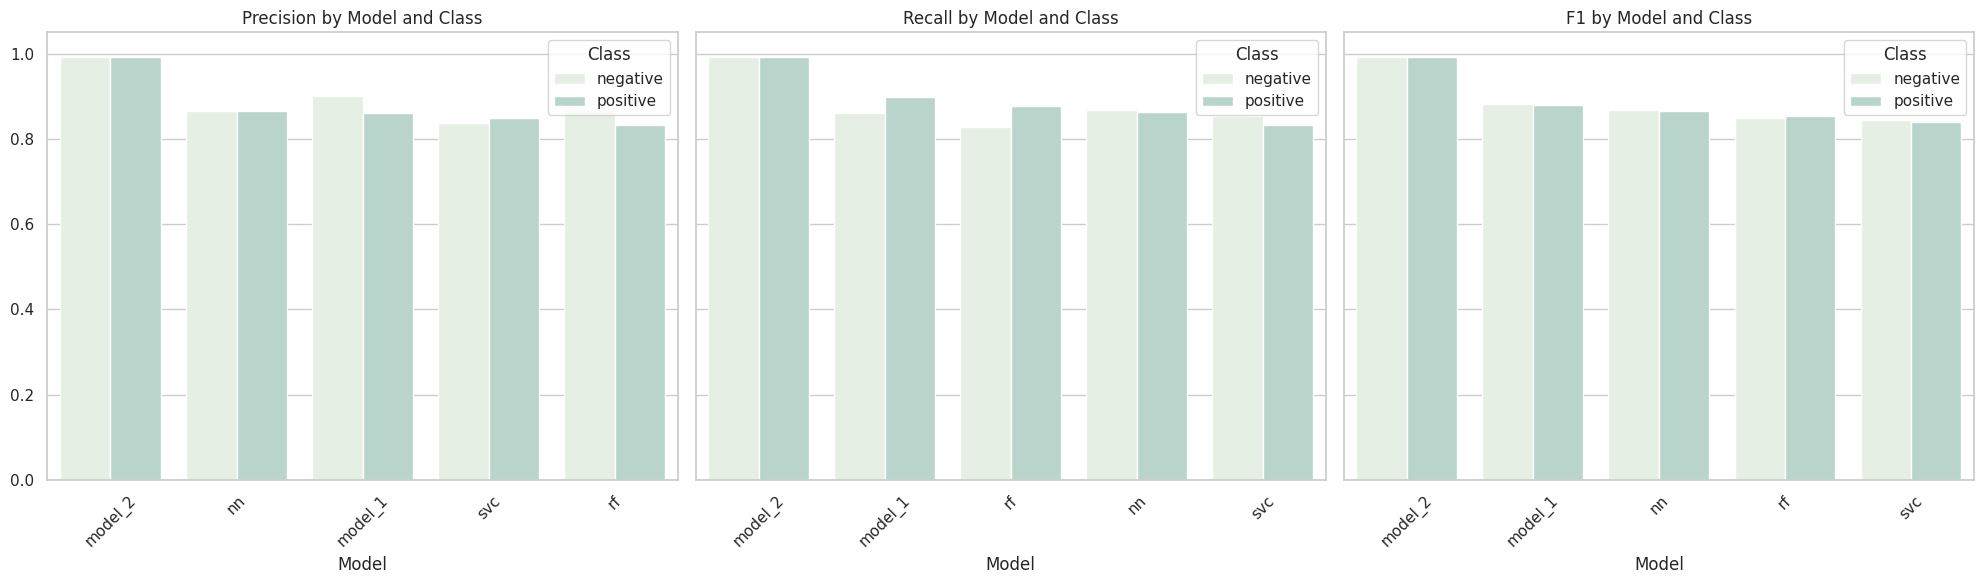

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import re

# Helper: Convert 'rgb(r, g, b)' → '#rrggbb'
def rgb_string_to_hex(rgb_str):
    r, g, b = map(int, re.findall(r'\d+', rgb_str))
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

# Convert Plotly Mint colors to hex
mint_rgb = px.colors.sequential.Mint
mint_palette = [rgb_string_to_hex(c) for c in mint_rgb]

# Normalize metrics
def normalize_metrics(metrics_dict):
    normalized = metrics_dict.copy()
    if 'f1-score' in normalized:
        if 'f1' not in normalized:
            normalized['f1'] = normalized['f1-score']
        else:
            normalized['f1'].update(normalized['f1-score'])
        del normalized['f1-score']
    return normalized

# Flatten dict into DataFrame
def flatten_metrics_dict(metrics_dict):
    rows = []
    for metric in ['precision', 'recall', 'f1']:
        if metric not in metrics_dict:
            continue
        for model_label, value in metrics_dict[metric].items():
            rows.append({
                'model': model_label,
                'metric': metric,
                'value': value
            })
    return pd.DataFrame(rows)

# Consistent colors for classes
hue_order = ['negative', 'positive']
class_palette = dict(zip(hue_order, mint_palette[:len(hue_order)]))

# Prepare DataFrame
normalized_metrics = normalize_metrics(models_metrics)
df_metrics = flatten_metrics_dict(normalized_metrics)
df_metrics[['model_name', 'class']] = df_metrics['model'].str.extract(r'^(.*)_(positive|negative)$')

# Set up plot
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot each metric
for i, metric in enumerate(['precision', 'recall', 'f1']):
    ax = axes[i]
    data = df_metrics[df_metrics['metric'] == metric]

    # Sort by value of positive class
    positive_vals = data[data['class'] == 'positive'].sort_values(by='value', ascending=False)
    model_order = positive_vals['model_name'].tolist()

    sns.barplot(
        data=data,
        x='model_name',
        y='value',
        hue='class',
        hue_order=hue_order,
        order=model_order,  # <-- Custom sort based on positive class
        palette=class_palette,
        ax=ax
    )
    ax.set_title(f'{metric.capitalize()} by Model and Class')
    ax.set_ylim(0, 1.05)
    ax.set_ylabel('')
    ax.set_xlabel('Model')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Class')

plt.tight_layout()
plt.show()
